### Experiment with preprocessed data

Since all of our data is passed through BERT every time, there's no reason to recompute the hidden outputs every time. 

This notebook updates the workflow such that we compile a pre-processed dataset, and the network we train will work directly on this preprocessed dataset, skipping BERT from the loop.

# Install and import modules

In [ ]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.6 MB/s eta 0:00:00


In [ ]:
import torch 
import torch.nn as nn
import transformers
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
import math
import copy
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# set manual seed 
np.random.seed(42)
torch.manual_seed(42)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import dataset from github

In [ ]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

# Set up data pipeline

In [ ]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
EBAT_filename = "EmoBank_AffectiveText.csv"
CHILDREN_filename = "children_highAgree.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))
df = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EBAT_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
df_children.head()

Children story dataset: 1207
Emobank dataset: 9814


Unnamed: 0                                           sentence  label
0           0  He looked around on every side and exclaimed, ...      4
1           1  Then he got up and clambered out of the cave, ...      3
2           2                    "Alas, thou canst not help me."      3
3           3  They leapt nimbly upstairs and downstairs, and...      2
4           4  Then she opened the door of the small house, a...      2

In [ ]:
df_emobank.head()

id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...

In [ ]:
# some global variables 
# EKMAN_EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
# EKMAN_MAP = {'H': 'joy', 'N': 'neutral', 'F': 'fear', 'A': 'anger', 'S': 'surprise', 'Sa': 'sadness', 'D': 'disgust'}
EKMAN_EMOTIONS = ['anger-disgust', 'fear', 'happy', 'sad', 'surprise']
NUM_CLASSES_EKMAN = 5
VAD_EMOTIONS = ['V', 'A', 'D']

EMOTION_NAMES = ['Ekman', 'VAD']
EMOTION_DIMS = [1, 3] # output dims

# Load data into numpy
x_ekman_raw = list(df_children['sentence'])
y_ekman_raw = df_children['label'].to_numpy()

x_vad_raw = list(df_emobank['text'])
y_vad_raw = df_emobank[VAD_EMOTIONS].to_numpy()

# Example:
print(x_ekman_raw[0])
print(y_ekman_raw[0])

print(x_vad_raw[0])
print(y_vad_raw[0])


He looked around on every side and exclaimed, "Oh, heavens, where am I?"
4
Remember what she said in my last letter? "
[3.  3.  3.2]


## Preprocess with tokenizer

In [ ]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

encoded_input = tokenizer(x_ekman_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_ekman_input = encoded_input['input_ids']
X_ekman_mask = encoded_input['attention_mask']

encoded_input = tokenizer(x_vad_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_vad_input = encoded_input['input_ids']
X_vad_mask = encoded_input['attention_mask']

# optional: delete df and x_text if the dataset is large

## Preprocess with BERT

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for param in bert.parameters():
  param.requires_grad = False
bert.to(DEVICE)
print(f'moved bert to {DEVICE}')

moved bert to cuda:0


In [ ]:
BERT_OUT_SIZE = 768

n_ekman = X_ekman_input.shape[0]
n_vad = X_vad_input.shape[0]
# make placeholder tensor for X
X_ekman = torch.empty(size=(n_ekman, BERT_OUT_SIZE), dtype=torch.float)
X_vad = torch.empty(size=(n_vad, BERT_OUT_SIZE), dtype=torch.float)

b = 100
num_batches = math.ceil(n_ekman // b)

# preprocess ekman
for i in tqdm(range(num_batches)):
  x_ids = X_ekman_input[i*b: (i+1)*b].to(DEVICE)
  x_masks = X_ekman_mask[i*b: (i+1)*b].to(DEVICE)

  output = bert(x_ids, attention_mask=x_masks)

  hidden_state = output['last_hidden_state']
  pooler_output = output['pooler_output']
  
  X_ekman[i*b: (i+1)*b] = pooler_output


num_batches = math.ceil(n_vad // b)
# preprocess vad
for i in tqdm(range(num_batches)):

  x_ids = X_vad_input[i*b: (i+1)*b].to(DEVICE)
  x_masks = X_vad_mask[i*b: (i+1)*b].to(DEVICE)

  output = bert(x_ids, attention_mask=x_masks)

  hidden_state = output['last_hidden_state']
  pooler_output = output['pooler_output']
  
  X_vad[i*b: (i+1)*b] = pooler_output


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
print(X_ekman.shape)
print(X_vad.shape)

torch.Size([1207, 768])
torch.Size([9814, 768])


In [ ]:
# process labels 
y_ekman_tensor = torch.tensor(y_ekman_raw, dtype=torch.float).unsqueeze(-1)
vad_placeholder = torch.zeros((len(y_ekman_tensor), EMOTION_DIMS[1]), )
y_ekman_tensor = torch.concatenate((y_ekman_tensor, vad_placeholder), dim=-1)

y_vad_tensor = torch.tensor(y_vad_raw, dtype=torch.float)
ekman_placeholder = torch.zeros((len(y_vad_tensor), EMOTION_DIMS[0]), )
y_vad_tensor = torch.concatenate((ekman_placeholder, y_vad_tensor), dim=-1)

# y_ekman is already categorical
y_vad_tensor = F.normalize(y_vad_tensor, dim=-1)

In [ ]:
1-(len(y_ekman_tensor)/10)/len(y_vad_tensor)*2

0.975402486244141

## Train-val-test split

* split ekman dataset into 80-10-10
* split vad s.t. val and test set is about 50-50 ekman vad

In [ ]:
def train_val_split(X, y, ratio):
  n = X.shape[0]

  perm = torch.randperm(n)

  train_size = int(ratio * n)

  X_train, y_train = X[perm[:train_size]], y[perm[:train_size]]
  X_val, y_val = X[perm[train_size:]], y[perm[train_size:]]

  return X_train, y_train, X_val, y_val

In [ ]:
# split into train-test
X_ekman_trainval, y_ekman_trainval, X_ekman_test, y_ekman_test = train_val_split(X_ekman, y_ekman_tensor, ratio=0.9)
X_ekman_train, y_ekman_train, X_ekman_val, y_ekman_val = train_val_split(X_ekman_trainval, y_ekman_trainval, ratio=8/9)

X_vad_train, y_vad_train, X_vad_testval, y_vad_testval = train_val_split(X_vad, y_vad_tensor, ratio=0.975)
X_vad_val, y_vad_val, X_vad_test, y_vad_test = train_val_split(X_vad_testval, y_vad_testval, ratio=0.5)


In [ ]:
print(f'number of ekman training points: {len(X_ekman_train)}')
print(f'number of ekman validation points: {len(X_ekman_val)}')
print(f'number of ekman testing points: {len(X_ekman_test)}')
print(f'number of vad training points: {len(X_vad_train)}')
print(f'number of vad validation points: {len(X_vad_val)}')
print(f'number of vad testing points: {len(X_vad_test)}')

number of ekman training points: 965
number of ekman validation points: 121
number of ekman testing points: 121
number of vad training points: 9568
number of vad validation points: 123
number of vad testing points: 123


In [ ]:
# attach task labels to the two tasks 
task_ekman_train = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_train), 1))
task_ekman_val = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_val), 1))
task_ekman_test = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_test), 1))

task_vad_train = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_train), 1))
task_vad_val = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_val), 1))
task_vad_test = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_test), 1))


In [ ]:
# Move everything to device
X_ekman_train = X_ekman_train.to(DEVICE)
y_ekman_train = y_ekman_train.to(DEVICE)
task_ekman_train = task_ekman_train.to(DEVICE)

X_ekman_val = X_ekman_val.to(DEVICE)
y_ekman_val = y_ekman_val.to(DEVICE)
task_ekman_val = task_ekman_val.to(DEVICE)

X_ekman_test = X_ekman_test.to(DEVICE)
y_ekman_test = y_ekman_test.to(DEVICE)
task_ekman_test = task_ekman_test.to(DEVICE)

X_vad_train = X_vad_train.to(DEVICE)
y_vad_train = y_vad_train.to(DEVICE)
task_vad_train = task_vad_train.to(DEVICE)

X_vad_val = X_vad_val.to(DEVICE)
y_vad_val = y_vad_val.to(DEVICE)
task_vad_val = task_vad_val.to(DEVICE)

X_vad_test = X_vad_test.to(DEVICE)
y_vad_test = y_vad_test.to(DEVICE)
task_vad_test = task_vad_test.to(DEVICE)

X_combined_train = torch.concatenate((X_ekman_train, X_vad_train), dim=0)
y_combined_train = torch.concatenate((y_ekman_train, y_vad_train), dim=0)
task_combined_train = torch.concatenate((task_ekman_train, task_vad_train), dim=0)

X_combined_val = torch.concatenate((X_ekman_val, X_vad_val), dim=0)
y_combined_val = torch.concatenate((y_ekman_val, y_vad_val), dim=0)
task_combined_val = torch.concatenate((task_ekman_val, task_vad_val), dim=0)

X_combined_test = torch.concatenate((X_ekman_test, X_vad_test), dim=0)
y_combined_test = torch.concatenate((y_ekman_test, y_vad_test), dim=0)
task_combined_test = torch.concatenate((task_ekman_test, task_vad_test), dim=0)

## Dataset

In [ ]:
class Emotion_dataset(Dataset):
  def __init__(self, X, y, task, transform=None):
    self.X = X
    self.y = y # [0.4, 0.4, 0.2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.1, 0.4, 0.1, 0.2, 0.1, 0.1]
    self.task = task # [[1, 0], [0, 1]]

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    sample = (self.X[idx], self.y[idx], self.task[idx])
    return sample


In [ ]:
ekman_train_dataset = Emotion_dataset(X_ekman_train, y_ekman_train, task_ekman_train)
ekman_val_dataset = Emotion_dataset(X_ekman_val, y_ekman_val, task_ekman_val)
ekman_test_dataset = Emotion_dataset(X_ekman_test, y_ekman_test, task_ekman_test)

vad_train_dataset = Emotion_dataset(X_vad_train, y_vad_train, task_vad_train)
vad_val_dataset = Emotion_dataset(X_vad_val, y_vad_val, task_vad_val)
vad_test_dataset = Emotion_dataset(X_vad_test, y_vad_test, task_vad_test)

combined_train_dataset = Emotion_dataset(X_combined_train, y_combined_train, task_combined_train)
combined_val_dataset = Emotion_dataset(X_combined_val, y_combined_val, task_combined_val)
combined_test_dataset = Emotion_dataset(X_combined_test, y_combined_test, task_combined_test)

dataset = {
    'ekman': {
        'train': ekman_train_dataset,
        'val': ekman_val_dataset,
        'test': ekman_test_dataset,
    },
    'vad': {
        'train': vad_train_dataset,
        'val': vad_val_dataset,
        'test': vad_test_dataset,
    },
    'combined': {
        'train': combined_train_dataset,
        'val': combined_val_dataset,
        'test': combined_test_dataset,
    }
}

In [ ]:
ekman_train_dataloader = DataLoader(dataset['ekman']['train'], batch_size = 30, shuffle=True)
ekman_val_dataloader = DataLoader(dataset['ekman']['val'], batch_size = 30, shuffle=True)
ekman_test_dataloader = DataLoader(dataset['ekman']['test'], batch_size = 30, shuffle=True)

vad_train_dataloader = DataLoader(dataset['vad']['train'], batch_size = 50, shuffle=True)
vad_val_dataloader = DataLoader(dataset['vad']['val'], batch_size = 50, shuffle=True)
vad_test_dataloader = DataLoader(dataset['vad']['test'], batch_size = 50, shuffle=True)

combined_train_dataloader = DataLoader(dataset['combined']['train'], batch_size = 50, shuffle=True)
combined_val_dataloader = DataLoader(dataset['combined']['val'], batch_size = 50, shuffle=True)
combined_test_dataloader = DataLoader(dataset['combined']['test'], batch_size = 50, shuffle=True)

dataloader = {
    'ekman': {
        'train': ekman_train_dataloader,
        'val': ekman_val_dataloader,
        'test': ekman_test_dataloader,
    },
    'vad': {
        'train': vad_train_dataloader,
        'val': vad_val_dataloader,
        'test': vad_test_dataloader,
    },
    'combined': {
        'train': combined_train_dataloader,
        'val': combined_val_dataloader,
        'test': combined_test_dataloader,
    }
}

print(f"number of batches in ekman training set: {len(dataloader['ekman']['train'])}")
print(f"number of batches in ekman val set: {len(dataloader['ekman']['val'])}")
print(f"number of batches in ekman test set: {len(dataloader['ekman']['test'])}")

# example batch
print('Sample batch:')
sample = next(iter(dataloader['combined']['train']))
X, y, task = sample

# example single data
# print(X[0])
print(y[0])
print(task[0])

# expected sample batch from seed:
# Sample batch:
# tensor([0.0000, 0.5693, 0.5931, 0.5693], device='cuda:0')
# tensor([0, 1], device='cuda:0')

number of batches in ekman training set: 33
number of batches in ekman val set: 5
number of batches in ekman test set: 5
Sample batch:
tensor([0.0000, 0.6114, 0.5595, 0.5595], device='cuda:0')
tensor([0, 1], device='cuda:0')


# Model Definition

In [ ]:
class MultiheadNetwork(nn.Module):
  def __init__(self, dropout=0):
    super().__init__()
    
    self.shared_base = nn.Linear(768, 256)
    self.ekman_predictor = nn.Linear(256, NUM_CLASSES_EKMAN)
    self.vad_predictor = nn.Linear(256, EMOTION_DIMS[1])

    self.dropout = nn.Dropout(p=dropout, inplace=False)
    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, X, task):  
    
    X = self.relu(self.shared_base(X))
    X = self.dropout(X)

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(X)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(X)
    y_vad = self.relu(y_vad)

    y = torch.concat((y_ekman, y_vad), dim=1)

    return y

In [ ]:
net = MultiheadNetwork()
net.to(DEVICE)

print(f'moved network to {DEVICE}')

moved network to cuda:0


In [ ]:
print([m.numel() for m in net.parameters() if m.requires_grad==True])

[196608, 256, 1280, 5, 768, 3]


In [ ]:
with torch.no_grad():
  sample = next(iter(dataloader['combined']['train']))
  X, y, task = sample

  y_pred = net(X, task)
y_pred[:10]

tensor([[-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0079,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0270,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0109,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0666,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0000,  0.0384],
        [-1.5507, -1.5010, -1.8451, -1.8568, -1.3831,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

# Loss Function

In [ ]:
class multiTaskLoss(object):
  def __init__(self):
    self.ekman_criterion = nn.CrossEntropyLoss(reduction='none')
    self.vad_criterion = nn.MSELoss(reduction='none')
  
  def __call__(self, y_pred, y_gt, task) -> torch.tensor:
    '''
    Returns as loss vector with one loss for each task, normalized to number of samples
    '''
    ekman_count = task[:, 0].sum()
    vad_count = task[:, 1].sum()

    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float, device=y_pred.device)

    # ekman loss (categorical)
    ekman_mask = task[:, 0]
    ekman_loss_unfiltered = self.ekman_criterion(y_pred[:, 0:5], y_gt[:, 0:1].squeeze(dim=1).to(int))
    ekman_loss = ekman_loss_unfiltered * ekman_mask
    if ekman_count > 0:
      losses[0] = ekman_loss.sum() / ekman_count
    else: 
      losses[0] = ekman_loss.sum()

    # vad loss (MSE)
    vad_mask = task[:, 1]
    vad_loss_unfiltered = self.vad_criterion(y_pred[:, 5:], y_gt[:, 1:]).sum(dim=-1)
    vad_loss = vad_loss_unfiltered *vad_mask
    if vad_count > 0:
      losses[1] = vad_loss.sum() / vad_count
    else:
      losses[1] = vad_loss.sum()
    return losses

# GradNorm

In [119]:
class GradNorm():
  def __init__(self, initial_loss, layers, alpha=1.0, weights=None):
    # the last share layer
    self.layers = layers
    # hyperparameter
    self.alpha = alpha
    if not weights:
      # init weights
      self.weights = torch.nn.Parameter(torch.ones_like(initial_loss))
    else:
      # take some custom initial weights
      self.weights = weights

    # set optimizer for weights
    self.optimizer_GradNorm = torch.optim.Adam([self.weights])

    # set L(0)
    self.l0 = initial_loss.clone().detach()

    self.updated_l0 = True

  def get_weights(self):
    return self.weights.clone().detach()
  
  def get_loss_ratios(self):
    return self.loss_ratio

  def update_L0(self, L0):
    self.l0 = L0.clone().detach()
    self.updated_l0 = True

  def update_weights(self, losses):
    # compute the L2 norm of the gradients for each task
    gw = []
    for i in range(len(losses)):
      dl = torch.autograd.grad(self.weights[i]*losses[i], self.layers.parameters(), retain_graph=True, create_graph=True)[0]
      # take norm of the gradient as proxy for how much it's updating
      gw.append(torch.norm(dl))
    gw = torch.stack(gw)
    # compute the average gradient norm
    gw_avg = gw.mean().detach()

    # compute loss ratio per task
    self.loss_ratio = losses.detach() / self.l0
    # compute the relative inverse training rate per task
    rt = self.loss_ratio / self.loss_ratio.mean()

    # compute the GradNorm loss
    constant = (gw_avg * rt ** self.alpha).detach()
    gradnorm_loss = torch.abs(gw - constant).sum()

    # clear gradients of weights
    self.optimizer_GradNorm.zero_grad()
    # backward pass for GradNorm
    # gradnorm_loss.backward(self.weights)
    
    weights_grad = torch.autograd.grad(gradnorm_loss, self.weights)
    self.weights._grad = weights_grad[0]
    # update loss weights
    self.optimizer_GradNorm.step()

    with torch.no_grad():
      normalizer = len(self.weights) / self.weights.sum()
      self.weights *= normalizer
    
    # print(self.weights)
    # renormalize weights
    # self.weights = torch.nn.Parameter((self.weights / self.weights.sum() * len(self.weights)).detach())

    # reset optimizer
    # self.optimizer_GradNorm = torch.optim.Adam([self.weights])

# Training Manager

In [ ]:
class TrainingManager():
  def __init__(self, net, dataloader, with_gradNorm=True, alpha = 1, max_epochs=100):
    self.alpha = alpha
    self.net = net
    self.dataloader = dataloader
    self.with_gradNorm = with_gradNorm

    # self.criterion = nn.MSELoss()
    self.criterion = multiTaskLoss()

    self.optimizer = torch.optim.Adam(self.net.parameters())

    if self.with_gradNorm:
      self.GN = None

    self.max_epochs = max_epochs
    self.num_epochs = 0

    self.curr_epoch = 0
    self.history = {
        'train_loss_ekman': [],
        'train_loss_vad': [],
        'train_loss_avg': [],
        'val_loss_ekman': [],
        'val_loss_vad': [],
        'val_loss_avg': [],
        'val_ekman_accuracy': [],
        'loss_weights': [],
        'loss_ratios': [],
    }

  def train(self, epochs, train_label='ekman', val_label='ekman'):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_avg = 0
      total_loss_weights = torch.zeros(2,)
      total_loss_ratios = torch.zeros(2,)

      for X, y, task in tqdm(self.dataloader[train_label]['train']):
        self.optimizer.zero_grad()

        y_pred = self.net(X, task)

        losses = self.criterion(y_pred, y, task)

        # GradNorm initialization (only on first step)
        if self.with_gradNorm:
          if self.GN == None:
            self.GN = GradNorm(losses, self.net.shared_base, self.alpha)
          if self.curr_epoch == 1 and not self.GN.updated_l0:
            self.GN.update_L0(L0_temp)
          # retreive weights first
          # weights = self.GN.get_weights()
          weights = self.GN.weights.clone().detach()
          # update weights
          self.GN.update_weights(losses)
          # see loss_ratio for logging
          loss_ratio = self.GN.get_loss_ratios()

          # log 
          total_loss_weights += weights.detach().cpu().clone()
          # task normalized loss
          total_loss_ratios += loss_ratio.detach().cpu().clone()

        else:
          weights = torch.ones_like(losses)

        # compute the weighted loss
        # TODO: check weights shape
        weighted_loss = weights @ losses

        # clear gradients of network
        self.optimizer.zero_grad()

        # retain graph because we still need to update weights
        weighted_loss.backward()

        # storing minibatch results
        # total_loss_ekman += (weights[0]*losses[0]).cpu().item()
        # total_loss_vad += (weights[1]*losses[1]).cpu().item()
        # total_loss_avg += torch.norm(weighted_loss).cpu().item()

        total_loss_ekman += losses[0].cpu().item()
        total_loss_vad += losses[1].cpu().item()
        total_loss_avg += torch.norm(losses).cpu().item()

        # update model weights
        self.optimizer.step()

      # storing epoch results
      val_loss_ekman, val_loss_vad, val_loss_avg, val_ekman_accuracy = self._evaluate(self.dataloader[val_label]['val'])
      
      log_loss_weights = (total_loss_weights / len(self.dataloader[train_label]['train'])).tolist()
      log_loss_ratios = (total_loss_ratios / len(self.dataloader[train_label]['train'])).tolist()
      
      total_loss_ekman /= len(self.dataloader[train_label]['train'])
      total_loss_vad /= len(self.dataloader[train_label]['train'])
      total_loss_avg /= len(self.dataloader[train_label]['train'])

      if not self.GN.updated_l0:
        print('recomputing L0...')
        l0_ekman, l0_vad, _, _ = self._evaluate(self.dataloader[train_label]['train'])
        L0_temp = torch.tensor([l0_ekman, l0_vad], device=y.device)
      
      self.curr_epoch += 1
      self.history['train_loss_ekman'].append(total_loss_ekman)
      self.history['train_loss_vad'].append(total_loss_vad)
      self.history['train_loss_avg'].append(total_loss_avg)
      self.history['val_loss_ekman'].append(val_loss_ekman.cpu().item())
      self.history['val_loss_vad'].append(val_loss_vad.cpu().item())
      self.history['val_loss_avg'].append(val_loss_avg.cpu().item())
      self.history['val_ekman_accuracy'].append(val_ekman_accuracy)
      self.history['loss_weights'].append(log_loss_weights)
      self.history['loss_ratios'].append(log_loss_ratios)

      print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {total_loss_ekman:.3f}, vad_loss = {total_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {val_loss_ekman:.3f}, vad_loss = {val_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_ekman_accuracy = {val_ekman_accuracy:.3f}')
      if self.with_gradNorm:
        print(f'Epoch {e+1}: avg. loss_weights = {log_loss_weights}')
        print(f'Epoch {e+1}: avg. loss_ratios (inv. train rate) = {log_loss_ratios}')
        print(f'{self.GN.l0}')

      self.num_epochs += 1
  
  def _evaluate(self, dataloader=None):
    self.net.eval()
    if dataloader == None:
      dataloader = self.dataloader['ekman']['test']
    with torch.no_grad():
      total_loss = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      total_ekman = 0 
      total_vad = 0 
      for X, y, task in tqdm(dataloader):
        y_pred = self.net(X, task)
        loss = self.criterion(y_pred, y, task)

        # print(y_pred[0:5])
        # print(y[0:5])

        y_top_gt = y[:, 0:1].to(int).squeeze(dim=-1)
        y_top_pred = torch.argmax(y_pred[:, 0:5], dim=-1)

        ekman_filter = task[:, 0].squeeze()
        vad_filter = task[:, 1].squeeze()

        total_ekman += ekman_filter.sum().item()
        total_vad += vad_filter.sum().item()

        ekman_top1_correct += (torch.where(y_top_gt == y_top_pred, torch.ones_like(y_top_gt), torch.zeros_like(y_top_gt))*ekman_filter).sum()
        
        total_loss_ekman += loss[0] * ekman_filter.sum().item()
        total_loss_vad += loss[1] * vad_filter.sum().item()
        total_loss += loss[0] * ekman_filter.sum().item() + loss[1] * vad_filter.sum().item()

    total_loss_ekman /= total_ekman
    total_loss_vad /= total_vad
    total_loss /= (total_vad + total_ekman)

    if total_ekman != 0:
      ekman_accuracy = ekman_top1_correct.item() / total_ekman
    else: 
      ekman_accuracy = 0

    return total_loss_ekman, total_loss_vad, total_loss, ekman_accuracy

  def evaluate(self, label='ekman'):
    ekman_loss, vad_loss, loss, acc = self._evaluate(self.dataloader[label]['test'])

    print(f'TEST SET ({label})')
    print(f'Avg Loss = {loss:.3f}')
    print(f'Ekman Loss = {ekman_loss:.3f}')
    print(f'VAD Loss = {vad_loss:.3f}')
    print(f'Accuracy = {acc * 100:.2f}')

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Weight')
    plt.plot([x[0] for x in self.history['loss_weights']], label='ekman')
    plt.plot([x[1] for x in self.history['loss_weights']], label='vad')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Ekman Loss')
    plt.plot(self.history['train_loss_ekman'], label='train')
    plt.plot(self.history['val_loss_ekman'], label='val')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('VAD Loss')
    plt.plot(self.history['train_loss_vad'], label='train')
    plt.plot(self.history['val_loss_vad'], label='val')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('Ekman top1 Accuracy')
    plt.plot(self.history['val_ekman_accuracy'], label='val')
    plt.legend()

    plt.show()

  def save_model(self, folder, filename, save_weights=True, save_logs=True):
    print('saving experiment...')
    filename += f'_{self.curr_epoch}e'
    if save_weights:
      torch.save(self.net.state_dict(), os.path.join(folder, filename+'.pt'))
  
    if save_logs:
      df_log = pd.DataFrame.from_dict(self.history)
      df_log.to_csv(os.path.join(folder, filename+'_logs.csv'))

      ekman_loss, vad_loss, loss, acc = self._evaluate(self.dataloader['combined']['test'])

      with open(os.path.join(folder, filename+'.txt'), 'w+') as f:
        f.write(f'{ekman_loss}, {vad_loss}, {loss}, {acc}')
      
    print(f'All files saved with experiment name = {filename} to folder {folder}')


# Average Results

### Summary Plot

In [109]:
from scipy.interpolate import make_interp_spline

def plot_summary(history, save_to=None):
    for key, value in history.items():
      history[key] = np.array(value)
      
    x = np.arange(history['train_loss_ekman'].shape[1]) + 1
    x_dense = np.linspace(x.min(), x.max(), 100)

    plt.figure(figsize=(20, 5))

    plots = [
        {
          'title': 'Weights',
          'lines': {
              'Ekman': history['loss_weights'][:, :, 0],
              'Vad': history['loss_weights'][:, :, 1]
            }
        },
        {
          'title': 'Ekman Loss',
          'lines': {
              'train': history['train_loss_ekman'],
              'val': history['val_loss_ekman']
            }
        },
        {
          'title': 'VAD Loss',
          'lines': {
              'train': history['train_loss_vad'],
              'val': history['val_loss_vad']
            }
        },
        {
          'title': 'Ekman Accuracy',
          'lines': {
              'val': history['val_ekman_accuracy'],
            }
        },
    ]

    colors = ['#00bb88', '#0033ff', '#aa3399', '#ff6600']
    for (i, plot) in enumerate(plots):
        plt.subplot(1, 4, i+1)
        plt.title(plot['title'])
        for j, (label, lines) in enumerate(plot['lines'].items()):
          mean =  lines.mean(axis=0).squeeze()
          std = lines.std(axis=0).squeeze()

          mean = make_interp_spline(x, mean)(x_dense)
          std = make_interp_spline(x, std)(x_dense)

          plt.plot(x_dense, mean, color=colors[j], label=label)
          plt.fill_between(x_dense, mean+std, mean-std, color=colors[j], alpha=0.3)
        plt.legend()
    plt.show()

    if save_to != None:
      plt.savefig(save_to, dpi=300)

In [110]:
import json

class Results_Summary():
  def __init__(self):
    self.history = {
        'train_loss_ekman': [],
        'train_loss_vad': [],
        'train_loss_avg': [],
        'val_loss_ekman': [],
        'val_loss_vad': [],
        'val_loss_avg': [],
        'val_ekman_accuracy': [],
        'loss_weights': [],
        'loss_ratios': [],
    }

    self.test_results = {
        'ekman_loss': [], 
        'vad_loss': [],
        'loss': [],
        'ekman_acc': [],
    }
  
  def add_history(self, history):
    for key, value in history.items():
      self.history[key].append(value)
  
  def add_test_results(self, test_results):
    for key, value in test_results.items():
      self.test_results[key].append(value)

  def plot_averaged_history(self, save_to=None):
    plot_summary(self.history, save_to)
  
  def save(self, folder, filename):
    json.dump(self.history, open(os.path.join(folder, filename+'.json'), 'w'))

  def show_test_summary(self):
    ekman_loss = np.array(self.test_results['ekman_loss'])
    print(f'Ekman Loss: {ekman_loss.mean():.3f} +- {ekman_loss.std():.3f}')
    vad_loss = np.array(self.test_results['vad_loss'])
    print(f'VAD Loss: {vad_loss.mean():.3f} +- {vad_loss.std():.3f}')
    loss = np.array(self.test_results['loss'])
    print(f'Avg Loss: {loss.mean():.3f} +- {loss.std():.3f}')
    ekman_acc = np.array(self.test_results['ekman_acc'])
    print(f'Avg Ekman Accuracy: {ekman_acc.mean():.3f} +- {ekman_acc.std():.3f}')



# Experiments

### Test pretrained dataset works

In [ ]:
net = MultiheadNetwork(dropout=0)
net.to(DEVICE)
training_manager_multi = TrainingManager(net, dataloader, with_gradNorm=True, alpha=1.0)

In [ ]:
training_manager_multi.evaluate('combined')

  0%|          | 0/5 [00:00<?, ?it/s]

TEST SET (combined)
Avg Loss = 1.229
Ekman Loss = 1.584
VAD Loss = 0.879
Accuracy = 38.84


In [ ]:
training_manager_multi.train(epochs=40, train_label='combined', val_label='combined')

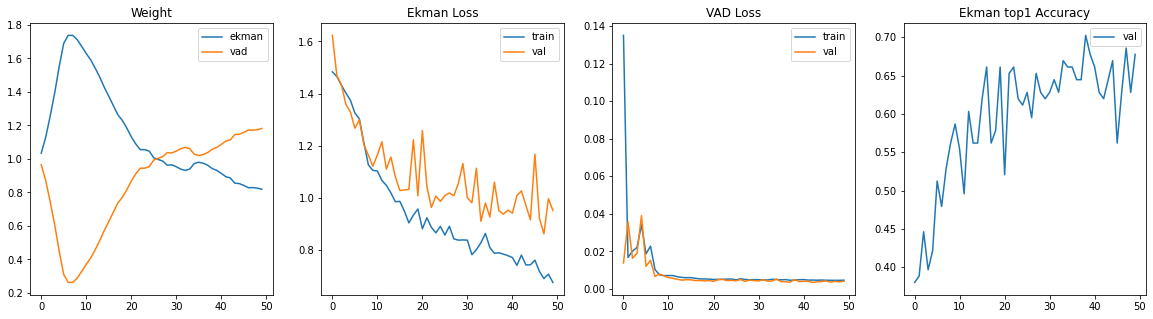

In [ ]:
training_manager_multi.plot_history()

## Dropout=0.5, GradNorm = 1, with L0 update



In [115]:
summary = Results_Summary()
for _ in range(5):
  net = MultiheadNetwork(dropout=0.5)
  net.to(DEVICE)

  exp2 = TrainingManager(net, dataloader, with_gradNorm=True, alpha=1.0)
  exp2.train(epochs=60, train_label='combined', val_label='combined')

  # evaluate on test set
  ekman_loss, vad_loss, loss, acc = exp2._evaluate(dataloader['combined']['test'])
  # append results
  test_results = {'ekman_loss': ekman_loss.item(), 'vad_loss': vad_loss.item(), 'loss': loss.item(), 'ekman_acc': acc,}
  summary.add_history(exp2.history)
  summary.add_test_results(test_results)


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

recomputing L0...


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.554
Epoch 1: ekman_loss = 1.550, vad_loss = 0.087
Epoch 1: val_avg_loss = 0.791
Epoch 1: ekman_loss = 1.577, vad_loss = 0.017
Epoch 1: val_ekman_accuracy = 0.331
Epoch 1: avg. loss_weights = [1.0521961450576782, 0.9478039741516113]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.9492462873458862, 0.12825268507003784]
tensor([1.6333, 0.6767], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.480
Epoch 2: ekman_loss = 1.479, vad_loss = 0.009
Epoch 2: val_avg_loss = 0.723
Epoch 2: ekman_loss = 1.444, vad_loss = 0.014
Epoch 2: val_ekman_accuracy = 0.347
Epoch 2: avg. loss_weights = [1.0620559453964233, 0.9379439949989319]
Epoch 2: avg. loss_ratios (inv. train rate) = [0.9738236665725708, 0.6179846525192261]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.451
Epoch 3: ekman_loss = 1.451, vad_loss = 0.009
Epoch 3: val_avg_loss = 0.700
Epoch 3: ekman_loss = 1.402, vad_loss = 0.009
Epoch 3: val_ekman_accuracy = 0.364
Epoch 3: avg. loss_weights = [0.9709845781326294, 1.0290155410766602]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9550977349281311, 0.5728501677513123]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.439
Epoch 4: ekman_loss = 1.439, vad_loss = 0.008
Epoch 4: val_avg_loss = 0.712
Epoch 4: ekman_loss = 1.428, vad_loss = 0.007
Epoch 4: val_ekman_accuracy = 0.380
Epoch 4: avg. loss_weights = [0.8522639274597168, 1.1477359533309937]
Epoch 4: avg. loss_ratios (inv. train rate) = [0.947371780872345, 0.5380585789680481]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.351
Epoch 5: ekman_loss = 1.351, vad_loss = 0.006
Epoch 5: val_avg_loss = 0.718
Epoch 5: ekman_loss = 1.437, vad_loss = 0.010
Epoch 5: val_ekman_accuracy = 0.397
Epoch 5: avg. loss_weights = [0.7229880094528198, 1.2770119905471802]
Epoch 5: avg. loss_ratios (inv. train rate) = [0.8889445066452026, 0.4000246226787567]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.345
Epoch 6: ekman_loss = 1.345, vad_loss = 0.006
Epoch 6: val_avg_loss = 0.658
Epoch 6: ekman_loss = 1.321, vad_loss = 0.005
Epoch 6: val_ekman_accuracy = 0.405
Epoch 6: avg. loss_weights = [0.5796526670455933, 1.4203470945358276]
Epoch 6: avg. loss_ratios (inv. train rate) = [0.8850867748260498, 0.3634262681007385]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.299
Epoch 7: ekman_loss = 1.299, vad_loss = 0.005
Epoch 7: val_avg_loss = 0.654
Epoch 7: ekman_loss = 1.314, vad_loss = 0.005
Epoch 7: val_ekman_accuracy = 0.364
Epoch 7: avg. loss_weights = [0.42167651653289795, 1.5783236026763916]
Epoch 7: avg. loss_ratios (inv. train rate) = [0.855156660079956, 0.3358323574066162]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.244
Epoch 8: ekman_loss = 1.244, vad_loss = 0.006
Epoch 8: val_avg_loss = 0.619
Epoch 8: ekman_loss = 1.242, vad_loss = 0.006
Epoch 8: val_ekman_accuracy = 0.521
Epoch 8: avg. loss_weights = [0.2440125197172165, 1.7559874057769775]
Epoch 8: avg. loss_ratios (inv. train rate) = [0.8186256289482117, 0.3631598651409149]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.236
Epoch 9: ekman_loss = 1.236, vad_loss = 0.004
Epoch 9: val_avg_loss = 0.617
Epoch 9: ekman_loss = 1.240, vad_loss = 0.005
Epoch 9: val_ekman_accuracy = 0.496
Epoch 9: avg. loss_weights = [0.09969629347324371, 1.9003031253814697]
Epoch 9: avg. loss_ratios (inv. train rate) = [0.8136603832244873, 0.28464633226394653]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.221
Epoch 10: ekman_loss = 1.221, vad_loss = 0.004
Epoch 10: val_avg_loss = 0.615
Epoch 10: ekman_loss = 1.235, vad_loss = 0.004
Epoch 10: val_ekman_accuracy = 0.545
Epoch 10: avg. loss_weights = [0.07555560767650604, 1.9244437217712402]
Epoch 10: avg. loss_ratios (inv. train rate) = [0.8037537932395935, 0.27961933612823486]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.193
Epoch 11: ekman_loss = 1.193, vad_loss = 0.004
Epoch 11: val_avg_loss = 0.623
Epoch 11: ekman_loss = 1.252, vad_loss = 0.004
Epoch 11: val_ekman_accuracy = 0.397
Epoch 11: avg. loss_weights = [0.08141185343265533, 1.9185885190963745]
Epoch 11: avg. loss_ratios (inv. train rate) = [0.7851327657699585, 0.26602447032928467]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.179
Epoch 12: ekman_loss = 1.179, vad_loss = 0.004
Epoch 12: val_avg_loss = 0.596
Epoch 12: ekman_loss = 1.198, vad_loss = 0.004
Epoch 12: val_ekman_accuracy = 0.479
Epoch 12: avg. loss_weights = [0.08966746181249619, 1.910333514213562]
Epoch 12: avg. loss_ratios (inv. train rate) = [0.7762669324874878, 0.2639409005641937]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.164
Epoch 13: ekman_loss = 1.163, vad_loss = 0.004
Epoch 13: val_avg_loss = 0.598
Epoch 13: ekman_loss = 1.201, vad_loss = 0.005
Epoch 13: val_ekman_accuracy = 0.537
Epoch 13: avg. loss_weights = [0.0962376818060875, 1.9037622213363647]
Epoch 13: avg. loss_ratios (inv. train rate) = [0.7658379673957825, 0.2654127776622772]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.146
Epoch 14: ekman_loss = 1.146, vad_loss = 0.004
Epoch 14: val_avg_loss = 0.581
Epoch 14: ekman_loss = 1.168, vad_loss = 0.005
Epoch 14: val_ekman_accuracy = 0.562
Epoch 14: avg. loss_weights = [0.08651966601610184, 1.9134800434112549]
Epoch 14: avg. loss_ratios (inv. train rate) = [0.7542192339897156, 0.2604805529117584]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.142
Epoch 15: ekman_loss = 1.142, vad_loss = 0.004
Epoch 15: val_avg_loss = 0.579
Epoch 15: ekman_loss = 1.162, vad_loss = 0.005
Epoch 15: val_ekman_accuracy = 0.529
Epoch 15: avg. loss_weights = [0.07942084223031998, 1.920578956604004]
Epoch 15: avg. loss_ratios (inv. train rate) = [0.7517018914222717, 0.25535860657691956]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.134
Epoch 16: ekman_loss = 1.134, vad_loss = 0.004
Epoch 16: val_avg_loss = 0.578
Epoch 16: ekman_loss = 1.160, vad_loss = 0.005
Epoch 16: val_ekman_accuracy = 0.537
Epoch 16: avg. loss_weights = [0.08636877685785294, 1.9136303663253784]
Epoch 16: avg. loss_ratios (inv. train rate) = [0.7466509342193604, 0.27077433466911316]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.111
Epoch 17: ekman_loss = 1.111, vad_loss = 0.004
Epoch 17: val_avg_loss = 0.559
Epoch 17: ekman_loss = 1.123, vad_loss = 0.004
Epoch 17: val_ekman_accuracy = 0.579
Epoch 17: avg. loss_weights = [0.07998374104499817, 1.9200166463851929]
Epoch 17: avg. loss_ratios (inv. train rate) = [0.7315630316734314, 0.26140427589416504]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 1.089
Epoch 18: ekman_loss = 1.089, vad_loss = 0.004
Epoch 18: val_avg_loss = 0.549
Epoch 18: ekman_loss = 1.103, vad_loss = 0.005
Epoch 18: val_ekman_accuracy = 0.628
Epoch 18: avg. loss_weights = [0.07662399113178253, 1.9233766794204712]
Epoch 18: avg. loss_ratios (inv. train rate) = [0.7170239686965942, 0.2590377926826477]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 1.068
Epoch 19: ekman_loss = 1.067, vad_loss = 0.004
Epoch 19: val_avg_loss = 0.531
Epoch 19: ekman_loss = 1.066, vad_loss = 0.004
Epoch 19: val_ekman_accuracy = 0.595
Epoch 19: avg. loss_weights = [0.07443970441818237, 1.9255602359771729]
Epoch 19: avg. loss_ratios (inv. train rate) = [0.7026346921920776, 0.2533491849899292]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 1.090
Epoch 20: ekman_loss = 1.090, vad_loss = 0.004
Epoch 20: val_avg_loss = 0.572
Epoch 20: ekman_loss = 1.148, vad_loss = 0.004
Epoch 20: val_ekman_accuracy = 0.521
Epoch 20: avg. loss_weights = [0.06487364321947098, 1.9351258277893066]
Epoch 20: avg. loss_ratios (inv. train rate) = [0.7176232933998108, 0.2501392364501953]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 1.064
Epoch 21: ekman_loss = 1.064, vad_loss = 0.004
Epoch 21: val_avg_loss = 0.512
Epoch 21: ekman_loss = 1.029, vad_loss = 0.004
Epoch 21: val_ekman_accuracy = 0.595
Epoch 21: avg. loss_weights = [0.07570201903581619, 1.9242982864379883]
Epoch 21: avg. loss_ratios (inv. train rate) = [0.7001368999481201, 0.25464239716529846]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 1.051
Epoch 22: ekman_loss = 1.051, vad_loss = 0.004
Epoch 22: val_avg_loss = 0.537
Epoch 22: ekman_loss = 1.077, vad_loss = 0.005
Epoch 22: val_ekman_accuracy = 0.562
Epoch 22: avg. loss_weights = [0.06324807554483414, 1.936752200126648]
Epoch 22: avg. loss_ratios (inv. train rate) = [0.6916029453277588, 0.25177478790283203]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 1.026
Epoch 23: ekman_loss = 1.026, vad_loss = 0.004
Epoch 23: val_avg_loss = 0.520
Epoch 23: ekman_loss = 1.045, vad_loss = 0.004
Epoch 23: val_ekman_accuracy = 0.562
Epoch 23: avg. loss_weights = [0.05539707839488983, 1.9446032047271729]
Epoch 23: avg. loss_ratios (inv. train rate) = [0.6752718687057495, 0.2469080537557602]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.998
Epoch 24: ekman_loss = 0.998, vad_loss = 0.004
Epoch 24: val_avg_loss = 0.491
Epoch 24: ekman_loss = 0.986, vad_loss = 0.004
Epoch 24: val_ekman_accuracy = 0.595
Epoch 24: avg. loss_weights = [0.057604432106018066, 1.942395567893982]
Epoch 24: avg. loss_ratios (inv. train rate) = [0.6566633582115173, 0.2506248652935028]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 1.016
Epoch 25: ekman_loss = 1.016, vad_loss = 0.004
Epoch 25: val_avg_loss = 0.520
Epoch 25: ekman_loss = 1.045, vad_loss = 0.004
Epoch 25: val_ekman_accuracy = 0.545
Epoch 25: avg. loss_weights = [0.05812396854162216, 1.941875696182251]
Epoch 25: avg. loss_ratios (inv. train rate) = [0.6690250635147095, 0.2539539337158203]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 1.015
Epoch 26: ekman_loss = 1.015, vad_loss = 0.004
Epoch 26: val_avg_loss = 0.508
Epoch 26: ekman_loss = 1.021, vad_loss = 0.004
Epoch 26: val_ekman_accuracy = 0.628
Epoch 26: avg. loss_weights = [0.05371543765068054, 1.9462844133377075]
Epoch 26: avg. loss_ratios (inv. train rate) = [0.6679084897041321, 0.2521432042121887]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.983
Epoch 27: ekman_loss = 0.983, vad_loss = 0.004
Epoch 27: val_avg_loss = 0.474
Epoch 27: ekman_loss = 0.952, vad_loss = 0.004
Epoch 27: val_ekman_accuracy = 0.645
Epoch 27: avg. loss_weights = [0.04548154026269913, 1.9545185565948486]
Epoch 27: avg. loss_ratios (inv. train rate) = [0.6471395492553711, 0.24169084429740906]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.981
Epoch 28: ekman_loss = 0.981, vad_loss = 0.004
Epoch 28: val_avg_loss = 0.472
Epoch 28: ekman_loss = 0.948, vad_loss = 0.004
Epoch 28: val_ekman_accuracy = 0.587
Epoch 28: avg. loss_weights = [0.04620635136961937, 1.9537937641143799]
Epoch 28: avg. loss_ratios (inv. train rate) = [0.6458191275596619, 0.24461299180984497]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.976
Epoch 29: ekman_loss = 0.976, vad_loss = 0.004
Epoch 29: val_avg_loss = 0.510
Epoch 29: ekman_loss = 1.025, vad_loss = 0.004
Epoch 29: val_ekman_accuracy = 0.612
Epoch 29: avg. loss_weights = [0.04810519516468048, 1.9518948793411255]
Epoch 29: avg. loss_ratios (inv. train rate) = [0.6426307559013367, 0.2433057725429535]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.927
Epoch 30: ekman_loss = 0.927, vad_loss = 0.004
Epoch 30: val_avg_loss = 0.500
Epoch 30: ekman_loss = 1.004, vad_loss = 0.004
Epoch 30: val_ekman_accuracy = 0.628
Epoch 30: avg. loss_weights = [0.040705300867557526, 1.9592949151992798]
Epoch 30: avg. loss_ratios (inv. train rate) = [0.6101697683334351, 0.24645192921161652]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.936
Epoch 31: ekman_loss = 0.936, vad_loss = 0.004
Epoch 31: val_avg_loss = 0.469
Epoch 31: ekman_loss = 0.941, vad_loss = 0.004
Epoch 31: val_ekman_accuracy = 0.628
Epoch 31: avg. loss_weights = [0.040010206401348114, 1.9599894285202026]
Epoch 31: avg. loss_ratios (inv. train rate) = [0.615928053855896, 0.24045975506305695]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.925
Epoch 32: ekman_loss = 0.925, vad_loss = 0.004
Epoch 32: val_avg_loss = 0.451
Epoch 32: ekman_loss = 0.905, vad_loss = 0.004
Epoch 32: val_ekman_accuracy = 0.653
Epoch 32: avg. loss_weights = [0.04018060863018036, 1.9598197937011719]
Epoch 32: avg. loss_ratios (inv. train rate) = [0.6086371541023254, 0.2432173639535904]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.945
Epoch 33: ekman_loss = 0.945, vad_loss = 0.004
Epoch 33: val_avg_loss = 0.445
Epoch 33: ekman_loss = 0.894, vad_loss = 0.004
Epoch 33: val_ekman_accuracy = 0.636
Epoch 33: avg. loss_weights = [0.0401306077837944, 1.9598689079284668]
Epoch 33: avg. loss_ratios (inv. train rate) = [0.6218780875205994, 0.2476612776517868]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.926
Epoch 34: ekman_loss = 0.926, vad_loss = 0.004
Epoch 34: val_avg_loss = 0.454
Epoch 34: ekman_loss = 0.912, vad_loss = 0.004
Epoch 34: val_ekman_accuracy = 0.653
Epoch 34: avg. loss_weights = [0.036023709923028946, 1.9639761447906494]
Epoch 34: avg. loss_ratios (inv. train rate) = [0.6097643971443176, 0.23829548060894012]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.883
Epoch 35: ekman_loss = 0.882, vad_loss = 0.004
Epoch 35: val_avg_loss = 0.528
Epoch 35: ekman_loss = 1.060, vad_loss = 0.004
Epoch 35: val_ekman_accuracy = 0.570
Epoch 35: avg. loss_weights = [0.03836545720696449, 1.961634874343872]
Epoch 35: avg. loss_ratios (inv. train rate) = [0.5808832049369812, 0.24211473762989044]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.898
Epoch 36: ekman_loss = 0.898, vad_loss = 0.004
Epoch 36: val_avg_loss = 0.462
Epoch 36: ekman_loss = 0.927, vad_loss = 0.004
Epoch 36: val_ekman_accuracy = 0.612
Epoch 36: avg. loss_weights = [0.035012491047382355, 1.9649875164031982]
Epoch 36: avg. loss_ratios (inv. train rate) = [0.5911674499511719, 0.24190519750118256]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.931
Epoch 37: ekman_loss = 0.931, vad_loss = 0.004
Epoch 37: val_avg_loss = 0.499
Epoch 37: ekman_loss = 1.002, vad_loss = 0.005
Epoch 37: val_ekman_accuracy = 0.620
Epoch 37: avg. loss_weights = [0.039571065455675125, 1.9604289531707764]
Epoch 37: avg. loss_ratios (inv. train rate) = [0.6126458644866943, 0.25216931104660034]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.911
Epoch 38: ekman_loss = 0.911, vad_loss = 0.004
Epoch 38: val_avg_loss = 0.496
Epoch 38: ekman_loss = 0.995, vad_loss = 0.004
Epoch 38: val_ekman_accuracy = 0.628
Epoch 38: avg. loss_weights = [0.03903980553150177, 1.9609601497650146]
Epoch 38: avg. loss_ratios (inv. train rate) = [0.5994843244552612, 0.24398082494735718]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.878
Epoch 39: ekman_loss = 0.878, vad_loss = 0.004
Epoch 39: val_avg_loss = 0.462
Epoch 39: ekman_loss = 0.927, vad_loss = 0.004
Epoch 39: val_ekman_accuracy = 0.628
Epoch 39: avg. loss_weights = [0.0353713221848011, 1.9646292924880981]
Epoch 39: avg. loss_ratios (inv. train rate) = [0.5781750679016113, 0.2390640377998352]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.874
Epoch 40: ekman_loss = 0.874, vad_loss = 0.004
Epoch 40: val_avg_loss = 0.443
Epoch 40: ekman_loss = 0.890, vad_loss = 0.004
Epoch 40: val_ekman_accuracy = 0.653
Epoch 40: avg. loss_weights = [0.03248307481408119, 1.9675168991088867]
Epoch 40: avg. loss_ratios (inv. train rate) = [0.5755356550216675, 0.24067215621471405]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.799
Epoch 41: ekman_loss = 0.799, vad_loss = 0.004
Epoch 41: val_avg_loss = 0.488
Epoch 41: ekman_loss = 0.979, vad_loss = 0.004
Epoch 41: val_ekman_accuracy = 0.579
Epoch 41: avg. loss_weights = [0.03208009526133537, 1.967920184135437]
Epoch 41: avg. loss_ratios (inv. train rate) = [0.5255994200706482, 0.23656873404979706]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.856
Epoch 42: ekman_loss = 0.856, vad_loss = 0.004
Epoch 42: val_avg_loss = 0.436
Epoch 42: ekman_loss = 0.875, vad_loss = 0.004
Epoch 42: val_ekman_accuracy = 0.653
Epoch 42: avg. loss_weights = [0.03208427131175995, 1.967915654182434]
Epoch 42: avg. loss_ratios (inv. train rate) = [0.5633506774902344, 0.2410009503364563]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.818
Epoch 43: ekman_loss = 0.817, vad_loss = 0.004
Epoch 43: val_avg_loss = 0.460
Epoch 43: ekman_loss = 0.923, vad_loss = 0.004
Epoch 43: val_ekman_accuracy = 0.661
Epoch 43: avg. loss_weights = [0.028405625373125076, 1.9715937376022339]
Epoch 43: avg. loss_ratios (inv. train rate) = [0.5380672216415405, 0.2356964647769928]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.824
Epoch 44: ekman_loss = 0.824, vad_loss = 0.004
Epoch 44: val_avg_loss = 0.472
Epoch 44: ekman_loss = 0.948, vad_loss = 0.004
Epoch 44: val_ekman_accuracy = 0.612
Epoch 44: avg. loss_weights = [0.029399201273918152, 1.970600962638855]
Epoch 44: avg. loss_ratios (inv. train rate) = [0.5421096086502075, 0.23707926273345947]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.821
Epoch 45: ekman_loss = 0.821, vad_loss = 0.004
Epoch 45: val_avg_loss = 0.476
Epoch 45: ekman_loss = 0.956, vad_loss = 0.004
Epoch 45: val_ekman_accuracy = 0.595
Epoch 45: avg. loss_weights = [0.02724192850291729, 1.9727576971054077]
Epoch 45: avg. loss_ratios (inv. train rate) = [0.5402887463569641, 0.24047744274139404]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.844
Epoch 46: ekman_loss = 0.844, vad_loss = 0.004
Epoch 46: val_avg_loss = 0.409
Epoch 46: ekman_loss = 0.821, vad_loss = 0.004
Epoch 46: val_ekman_accuracy = 0.678
Epoch 46: avg. loss_weights = [0.028755774721503258, 1.9712436199188232]
Epoch 46: avg. loss_ratios (inv. train rate) = [0.5553528070449829, 0.23783281445503235]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.806
Epoch 47: ekman_loss = 0.806, vad_loss = 0.004
Epoch 47: val_avg_loss = 0.432
Epoch 47: ekman_loss = 0.868, vad_loss = 0.004
Epoch 47: val_ekman_accuracy = 0.678
Epoch 47: avg. loss_weights = [0.029489666223526, 1.9705113172531128]
Epoch 47: avg. loss_ratios (inv. train rate) = [0.5302919745445251, 0.24479007720947266]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.865
Epoch 48: ekman_loss = 0.865, vad_loss = 0.004
Epoch 48: val_avg_loss = 0.471
Epoch 48: ekman_loss = 0.945, vad_loss = 0.004
Epoch 48: val_ekman_accuracy = 0.628
Epoch 48: avg. loss_weights = [0.026543332263827324, 1.9734567403793335]
Epoch 48: avg. loss_ratios (inv. train rate) = [0.5696507096290588, 0.23941604793071747]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.812
Epoch 49: ekman_loss = 0.812, vad_loss = 0.004
Epoch 49: val_avg_loss = 0.486
Epoch 49: ekman_loss = 0.976, vad_loss = 0.005
Epoch 49: val_ekman_accuracy = 0.603
Epoch 49: avg. loss_weights = [0.026532752439379692, 1.9734679460525513]
Epoch 49: avg. loss_ratios (inv. train rate) = [0.5342453718185425, 0.2364632487297058]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.762
Epoch 50: ekman_loss = 0.762, vad_loss = 0.004
Epoch 50: val_avg_loss = 0.409
Epoch 50: ekman_loss = 0.821, vad_loss = 0.004
Epoch 50: val_ekman_accuracy = 0.678
Epoch 50: avg. loss_weights = [0.02588769420981407, 1.9741121530532837]
Epoch 50: avg. loss_ratios (inv. train rate) = [0.501547634601593, 0.2405170202255249]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: train_avg_loss = 0.786
Epoch 51: ekman_loss = 0.786, vad_loss = 0.004
Epoch 51: val_avg_loss = 0.437
Epoch 51: ekman_loss = 0.878, vad_loss = 0.004
Epoch 51: val_ekman_accuracy = 0.661
Epoch 51: avg. loss_weights = [0.024739855900406837, 1.9752599000930786]
Epoch 51: avg. loss_ratios (inv. train rate) = [0.5173692107200623, 0.23158159852027893]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: train_avg_loss = 0.798
Epoch 52: ekman_loss = 0.798, vad_loss = 0.004
Epoch 52: val_avg_loss = 0.435
Epoch 52: ekman_loss = 0.874, vad_loss = 0.004
Epoch 52: val_ekman_accuracy = 0.669
Epoch 52: avg. loss_weights = [0.026514695957303047, 1.9734851121902466]
Epoch 52: avg. loss_ratios (inv. train rate) = [0.5252830982208252, 0.23705272376537323]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: train_avg_loss = 0.789
Epoch 53: ekman_loss = 0.789, vad_loss = 0.004
Epoch 53: val_avg_loss = 0.467
Epoch 53: ekman_loss = 0.937, vad_loss = 0.004
Epoch 53: val_ekman_accuracy = 0.628
Epoch 53: avg. loss_weights = [0.024166477844119072, 1.9758338928222656]
Epoch 53: avg. loss_ratios (inv. train rate) = [0.5192176699638367, 0.2350034862756729]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: train_avg_loss = 0.810
Epoch 54: ekman_loss = 0.810, vad_loss = 0.004
Epoch 54: val_avg_loss = 0.399
Epoch 54: ekman_loss = 0.801, vad_loss = 0.004
Epoch 54: val_ekman_accuracy = 0.669
Epoch 54: avg. loss_weights = [0.0251444261521101, 1.9748561382293701]
Epoch 54: avg. loss_ratios (inv. train rate) = [0.5331982374191284, 0.23417288064956665]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: train_avg_loss = 0.726
Epoch 55: ekman_loss = 0.726, vad_loss = 0.003
Epoch 55: val_avg_loss = 0.494
Epoch 55: ekman_loss = 0.992, vad_loss = 0.004
Epoch 55: val_ekman_accuracy = 0.603
Epoch 55: avg. loss_weights = [0.02052483893930912, 1.9794747829437256]
Epoch 55: avg. loss_ratios (inv. train rate) = [0.47760841250419617, 0.2281160056591034]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: train_avg_loss = 0.792
Epoch 56: ekman_loss = 0.792, vad_loss = 0.004
Epoch 56: val_avg_loss = 0.406
Epoch 56: ekman_loss = 0.814, vad_loss = 0.004
Epoch 56: val_ekman_accuracy = 0.669
Epoch 56: avg. loss_weights = [0.022971419617533684, 1.9770286083221436]
Epoch 56: avg. loss_ratios (inv. train rate) = [0.5213739275932312, 0.23806412518024445]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: train_avg_loss = 0.788
Epoch 57: ekman_loss = 0.788, vad_loss = 0.004
Epoch 57: val_avg_loss = 0.459
Epoch 57: ekman_loss = 0.921, vad_loss = 0.004
Epoch 57: val_ekman_accuracy = 0.603
Epoch 57: avg. loss_weights = [0.02329406328499317, 1.9767063856124878]
Epoch 57: avg. loss_ratios (inv. train rate) = [0.5184913873672485, 0.23167631030082703]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: train_avg_loss = 0.760
Epoch 58: ekman_loss = 0.760, vad_loss = 0.004
Epoch 58: val_avg_loss = 0.543
Epoch 58: ekman_loss = 1.092, vad_loss = 0.004
Epoch 58: val_ekman_accuracy = 0.612
Epoch 58: avg. loss_weights = [0.01928647793829441, 1.9807138442993164]
Epoch 58: avg. loss_ratios (inv. train rate) = [0.5000618100166321, 0.2379097193479538]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: train_avg_loss = 0.742
Epoch 59: ekman_loss = 0.742, vad_loss = 0.004
Epoch 59: val_avg_loss = 0.499
Epoch 59: ekman_loss = 1.002, vad_loss = 0.004
Epoch 59: val_ekman_accuracy = 0.612
Epoch 59: avg. loss_weights = [0.023843973875045776, 1.9761558771133423]
Epoch 59: avg. loss_ratios (inv. train rate) = [0.48860964179039, 0.24092261493206024]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: train_avg_loss = 0.789
Epoch 60: ekman_loss = 0.789, vad_loss = 0.004
Epoch 60: val_avg_loss = 0.833
Epoch 60: ekman_loss = 1.675, vad_loss = 0.004
Epoch 60: val_ekman_accuracy = 0.446
Epoch 60: avg. loss_weights = [0.019395964220166206, 1.9806036949157715]
Epoch 60: avg. loss_ratios (inv. train rate) = [0.5191605687141418, 0.23039600253105164]
tensor([1.5192, 0.0153], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

recomputing L0...


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.546
Epoch 1: ekman_loss = 1.540, vad_loss = 0.102
Epoch 1: val_avg_loss = 0.758
Epoch 1: ekman_loss = 1.507, vad_loss = 0.022
Epoch 1: val_ekman_accuracy = 0.331
Epoch 1: avg. loss_weights = [1.0530643463134766, 0.9469357132911682]
Epoch 1: avg. loss_ratios (inv. train rate) = [1.0085312128067017, 0.14365999400615692]
tensor([1.5270, 0.7079], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.470
Epoch 2: ekman_loss = 1.470, vad_loss = 0.010
Epoch 2: val_avg_loss = 0.732
Epoch 2: ekman_loss = 1.467, vad_loss = 0.009
Epoch 2: val_ekman_accuracy = 0.289
Epoch 2: avg. loss_weights = [1.06557035446167, 0.9344297051429749]
Epoch 2: avg. loss_ratios (inv. train rate) = [0.9229685068130493, 0.462140291929245]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.456
Epoch 3: ekman_loss = 1.456, vad_loss = 0.009
Epoch 3: val_avg_loss = 0.744
Epoch 3: ekman_loss = 1.488, vad_loss = 0.011
Epoch 3: val_ekman_accuracy = 0.347
Epoch 3: avg. loss_weights = [0.9866163730621338, 1.0133835077285767]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9141373634338379, 0.4171433746814728]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.397
Epoch 4: ekman_loss = 1.397, vad_loss = 0.007
Epoch 4: val_avg_loss = 0.722
Epoch 4: ekman_loss = 1.450, vad_loss = 0.006
Epoch 4: val_ekman_accuracy = 0.314
Epoch 4: avg. loss_weights = [0.8891590237617493, 1.110840916633606]
Epoch 4: avg. loss_ratios (inv. train rate) = [0.8773724436759949, 0.32545390725135803]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.387
Epoch 5: ekman_loss = 1.387, vad_loss = 0.006
Epoch 5: val_avg_loss = 0.715
Epoch 5: ekman_loss = 1.436, vad_loss = 0.005
Epoch 5: val_ekman_accuracy = 0.347
Epoch 5: avg. loss_weights = [0.7744413018226624, 1.2255580425262451]
Epoch 5: avg. loss_ratios (inv. train rate) = [0.8711026310920715, 0.27961012721061707]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.354
Epoch 6: ekman_loss = 1.354, vad_loss = 0.005
Epoch 6: val_avg_loss = 0.689
Epoch 6: ekman_loss = 1.384, vad_loss = 0.005
Epoch 6: val_ekman_accuracy = 0.421
Epoch 6: avg. loss_weights = [0.6367890238761902, 1.3632111549377441]
Epoch 6: avg. loss_ratios (inv. train rate) = [0.850446879863739, 0.24816036224365234]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.249
Epoch 7: ekman_loss = 1.249, vad_loss = 0.005
Epoch 7: val_avg_loss = 0.662
Epoch 7: ekman_loss = 1.330, vad_loss = 0.005
Epoch 7: val_ekman_accuracy = 0.355
Epoch 7: avg. loss_weights = [0.4748879373073578, 1.5251123905181885]
Epoch 7: avg. loss_ratios (inv. train rate) = [0.7844123244285583, 0.23388132452964783]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.233
Epoch 8: ekman_loss = 1.233, vad_loss = 0.006
Epoch 8: val_avg_loss = 0.647
Epoch 8: ekman_loss = 1.300, vad_loss = 0.004
Epoch 8: val_ekman_accuracy = 0.397
Epoch 8: avg. loss_weights = [0.29825901985168457, 1.7017408609390259]
Epoch 8: avg. loss_ratios (inv. train rate) = [0.7742077708244324, 0.27812835574150085]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.218
Epoch 9: ekman_loss = 1.218, vad_loss = 0.004
Epoch 9: val_avg_loss = 0.631
Epoch 9: ekman_loss = 1.269, vad_loss = 0.004
Epoch 9: val_ekman_accuracy = 0.405
Epoch 9: avg. loss_weights = [0.1560431718826294, 1.843956708908081]
Epoch 9: avg. loss_ratios (inv. train rate) = [0.7646880745887756, 0.20752201974391937]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.208
Epoch 10: ekman_loss = 1.208, vad_loss = 0.004
Epoch 10: val_avg_loss = 0.622
Epoch 10: ekman_loss = 1.249, vad_loss = 0.004
Epoch 10: val_ekman_accuracy = 0.405
Epoch 10: avg. loss_weights = [0.1015809029340744, 1.898419737815857]
Epoch 10: avg. loss_ratios (inv. train rate) = [0.758614182472229, 0.19791767001152039]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.159
Epoch 11: ekman_loss = 1.159, vad_loss = 0.004
Epoch 11: val_avg_loss = 0.601
Epoch 11: ekman_loss = 1.206, vad_loss = 0.005
Epoch 11: val_ekman_accuracy = 0.471
Epoch 11: avg. loss_weights = [0.11355602741241455, 1.8864452838897705]
Epoch 11: avg. loss_ratios (inv. train rate) = [0.7275562286376953, 0.19474710524082184]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.197
Epoch 12: ekman_loss = 1.197, vad_loss = 0.004
Epoch 12: val_avg_loss = 0.612
Epoch 12: ekman_loss = 1.229, vad_loss = 0.004
Epoch 12: val_ekman_accuracy = 0.529
Epoch 12: avg. loss_weights = [0.12156812101602554, 1.878431797027588]
Epoch 12: avg. loss_ratios (inv. train rate) = [0.7514990568161011, 0.1921214908361435]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.176
Epoch 13: ekman_loss = 1.175, vad_loss = 0.005
Epoch 13: val_avg_loss = 0.605
Epoch 13: ekman_loss = 1.201, vad_loss = 0.019
Epoch 13: val_ekman_accuracy = 0.554
Epoch 13: avg. loss_weights = [0.11620908975601196, 1.8837909698486328]
Epoch 13: avg. loss_ratios (inv. train rate) = [0.7380539774894714, 0.21391040086746216]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.149
Epoch 14: ekman_loss = 1.149, vad_loss = 0.004
Epoch 14: val_avg_loss = 0.594
Epoch 14: ekman_loss = 1.193, vad_loss = 0.004
Epoch 14: val_ekman_accuracy = 0.430
Epoch 14: avg. loss_weights = [0.11633042991161346, 1.883669137954712]
Epoch 14: avg. loss_ratios (inv. train rate) = [0.7213826179504395, 0.20420344173908234]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.156
Epoch 15: ekman_loss = 1.156, vad_loss = 0.004
Epoch 15: val_avg_loss = 0.572
Epoch 15: ekman_loss = 1.148, vad_loss = 0.005
Epoch 15: val_ekman_accuracy = 0.545
Epoch 15: avg. loss_weights = [0.1090158224105835, 1.8909839391708374]
Epoch 15: avg. loss_ratios (inv. train rate) = [0.7255700826644897, 0.18900831043720245]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.130
Epoch 16: ekman_loss = 1.130, vad_loss = 0.004
Epoch 16: val_avg_loss = 0.584
Epoch 16: ekman_loss = 1.172, vad_loss = 0.005
Epoch 16: val_ekman_accuracy = 0.570
Epoch 16: avg. loss_weights = [0.09948951005935669, 1.9005104303359985]
Epoch 16: avg. loss_ratios (inv. train rate) = [0.7093033194541931, 0.19001246988773346]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.088
Epoch 17: ekman_loss = 1.088, vad_loss = 0.004
Epoch 17: val_avg_loss = 0.554
Epoch 17: ekman_loss = 1.112, vad_loss = 0.005
Epoch 17: val_ekman_accuracy = 0.570
Epoch 17: avg. loss_weights = [0.08690337091684341, 1.9130966663360596]
Epoch 17: avg. loss_ratios (inv. train rate) = [0.6830875277519226, 0.18467243015766144]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 1.081
Epoch 18: ekman_loss = 1.081, vad_loss = 0.004
Epoch 18: val_avg_loss = 0.557
Epoch 18: ekman_loss = 1.120, vad_loss = 0.004
Epoch 18: val_ekman_accuracy = 0.537
Epoch 18: avg. loss_weights = [0.09911316633224487, 1.900887131690979]
Epoch 18: avg. loss_ratios (inv. train rate) = [0.6789824366569519, 0.19753409922122955]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 1.044
Epoch 19: ekman_loss = 1.044, vad_loss = 0.004
Epoch 19: val_avg_loss = 0.559
Epoch 19: ekman_loss = 1.122, vad_loss = 0.005
Epoch 19: val_ekman_accuracy = 0.545
Epoch 19: avg. loss_weights = [0.07367824018001556, 1.9263217449188232]
Epoch 19: avg. loss_ratios (inv. train rate) = [0.6552828550338745, 0.18175123631954193]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 1.050
Epoch 20: ekman_loss = 1.050, vad_loss = 0.004
Epoch 20: val_avg_loss = 0.551
Epoch 20: ekman_loss = 1.106, vad_loss = 0.004
Epoch 20: val_ekman_accuracy = 0.587
Epoch 20: avg. loss_weights = [0.06622934341430664, 1.933770775794983]
Epoch 20: avg. loss_ratios (inv. train rate) = [0.6594048142433167, 0.18852756917476654]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 1.026
Epoch 21: ekman_loss = 1.026, vad_loss = 0.004
Epoch 21: val_avg_loss = 0.535
Epoch 21: ekman_loss = 1.074, vad_loss = 0.006
Epoch 21: val_ekman_accuracy = 0.537
Epoch 21: avg. loss_weights = [0.07493424415588379, 1.925066351890564]
Epoch 21: avg. loss_ratios (inv. train rate) = [0.6442501544952393, 0.18097180128097534]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 1.039
Epoch 22: ekman_loss = 1.039, vad_loss = 0.004
Epoch 22: val_avg_loss = 0.519
Epoch 22: ekman_loss = 1.042, vad_loss = 0.005
Epoch 22: val_ekman_accuracy = 0.587
Epoch 22: avg. loss_weights = [0.07114992290735245, 1.9288504123687744]
Epoch 22: avg. loss_ratios (inv. train rate) = [0.6524455547332764, 0.18392428755760193]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 1.012
Epoch 23: ekman_loss = 1.012, vad_loss = 0.004
Epoch 23: val_avg_loss = 0.507
Epoch 23: ekman_loss = 1.017, vad_loss = 0.004
Epoch 23: val_ekman_accuracy = 0.612
Epoch 23: avg. loss_weights = [0.0624706894159317, 1.9375299215316772]
Epoch 23: avg. loss_ratios (inv. train rate) = [0.6355428695678711, 0.18447674810886383]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 1.004
Epoch 24: ekman_loss = 1.004, vad_loss = 0.004
Epoch 24: val_avg_loss = 0.493
Epoch 24: ekman_loss = 0.989, vad_loss = 0.004
Epoch 24: val_ekman_accuracy = 0.628
Epoch 24: avg. loss_weights = [0.052830521017313004, 1.9471687078475952]
Epoch 24: avg. loss_ratios (inv. train rate) = [0.6303720474243164, 0.17835235595703125]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.995
Epoch 25: ekman_loss = 0.995, vad_loss = 0.004
Epoch 25: val_avg_loss = 0.567
Epoch 25: ekman_loss = 1.140, vad_loss = 0.004
Epoch 25: val_ekman_accuracy = 0.488
Epoch 25: avg. loss_weights = [0.060666508972644806, 1.9393336772918701]
Epoch 25: avg. loss_ratios (inv. train rate) = [0.6245916485786438, 0.18105657398700714]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.969
Epoch 26: ekman_loss = 0.969, vad_loss = 0.004
Epoch 26: val_avg_loss = 0.475
Epoch 26: ekman_loss = 0.953, vad_loss = 0.005
Epoch 26: val_ekman_accuracy = 0.628
Epoch 26: avg. loss_weights = [0.05042994022369385, 1.9495701789855957]
Epoch 26: avg. loss_ratios (inv. train rate) = [0.6084120273590088, 0.1810901015996933]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.939
Epoch 27: ekman_loss = 0.939, vad_loss = 0.004
Epoch 27: val_avg_loss = 0.456
Epoch 27: ekman_loss = 0.916, vad_loss = 0.004
Epoch 27: val_ekman_accuracy = 0.620
Epoch 27: avg. loss_weights = [0.05045663192868233, 1.9495433568954468]
Epoch 27: avg. loss_ratios (inv. train rate) = [0.5897068977355957, 0.17381754517555237]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.945
Epoch 28: ekman_loss = 0.945, vad_loss = 0.004
Epoch 28: val_avg_loss = 0.499
Epoch 28: ekman_loss = 1.003, vad_loss = 0.004
Epoch 28: val_ekman_accuracy = 0.620
Epoch 28: avg. loss_weights = [0.0479317307472229, 1.9520684480667114]
Epoch 28: avg. loss_ratios (inv. train rate) = [0.5934489369392395, 0.18181928992271423]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.973
Epoch 29: ekman_loss = 0.973, vad_loss = 0.004
Epoch 29: val_avg_loss = 0.517
Epoch 29: ekman_loss = 1.039, vad_loss = 0.004
Epoch 29: val_ekman_accuracy = 0.603
Epoch 29: avg. loss_weights = [0.0465720035135746, 1.9534275531768799]
Epoch 29: avg. loss_ratios (inv. train rate) = [0.6108943223953247, 0.17404118180274963]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.965
Epoch 30: ekman_loss = 0.965, vad_loss = 0.004
Epoch 30: val_avg_loss = 0.487
Epoch 30: ekman_loss = 0.978, vad_loss = 0.004
Epoch 30: val_ekman_accuracy = 0.587
Epoch 30: avg. loss_weights = [0.05356741324067116, 1.9464329481124878]
Epoch 30: avg. loss_ratios (inv. train rate) = [0.6061415672302246, 0.1818842887878418]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.913
Epoch 31: ekman_loss = 0.913, vad_loss = 0.004
Epoch 31: val_avg_loss = 0.477
Epoch 31: ekman_loss = 0.958, vad_loss = 0.004
Epoch 31: val_ekman_accuracy = 0.587
Epoch 31: avg. loss_weights = [0.05505695939064026, 1.9449435472488403]
Epoch 31: avg. loss_ratios (inv. train rate) = [0.573235273361206, 0.18141871690750122]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.896
Epoch 32: ekman_loss = 0.896, vad_loss = 0.004
Epoch 32: val_avg_loss = 0.474
Epoch 32: ekman_loss = 0.952, vad_loss = 0.004
Epoch 32: val_ekman_accuracy = 0.579
Epoch 32: avg. loss_weights = [0.059940487146377563, 1.940060019493103]
Epoch 32: avg. loss_ratios (inv. train rate) = [0.5627878308296204, 0.18120020627975464]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.917
Epoch 33: ekman_loss = 0.917, vad_loss = 0.004
Epoch 33: val_avg_loss = 0.454
Epoch 33: ekman_loss = 0.911, vad_loss = 0.005
Epoch 33: val_ekman_accuracy = 0.636
Epoch 33: avg. loss_weights = [0.05130228027701378, 1.948697805404663]
Epoch 33: avg. loss_ratios (inv. train rate) = [0.575584352016449, 0.18423967063426971]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.879
Epoch 34: ekman_loss = 0.879, vad_loss = 0.004
Epoch 34: val_avg_loss = 0.445
Epoch 34: ekman_loss = 0.893, vad_loss = 0.004
Epoch 34: val_ekman_accuracy = 0.645
Epoch 34: avg. loss_weights = [0.039415039122104645, 1.9605846405029297]
Epoch 34: avg. loss_ratios (inv. train rate) = [0.5518600344657898, 0.17144964635372162]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.871
Epoch 35: ekman_loss = 0.870, vad_loss = 0.004
Epoch 35: val_avg_loss = 0.486
Epoch 35: ekman_loss = 0.975, vad_loss = 0.004
Epoch 35: val_ekman_accuracy = 0.628
Epoch 35: avg. loss_weights = [0.039148688316345215, 1.9608513116836548]
Epoch 35: avg. loss_ratios (inv. train rate) = [0.5465186238288879, 0.17786622047424316]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.878
Epoch 36: ekman_loss = 0.878, vad_loss = 0.004
Epoch 36: val_avg_loss = 0.562
Epoch 36: ekman_loss = 1.129, vad_loss = 0.004
Epoch 36: val_ekman_accuracy = 0.545
Epoch 36: avg. loss_weights = [0.043314240872859955, 1.9566856622695923]
Epoch 36: avg. loss_ratios (inv. train rate) = [0.551275372505188, 0.17645223438739777]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.906
Epoch 37: ekman_loss = 0.906, vad_loss = 0.004
Epoch 37: val_avg_loss = 0.449
Epoch 37: ekman_loss = 0.902, vad_loss = 0.005
Epoch 37: val_ekman_accuracy = 0.595
Epoch 37: avg. loss_weights = [0.0439932681620121, 1.956006407737732]
Epoch 37: avg. loss_ratios (inv. train rate) = [0.568774402141571, 0.17790068686008453]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.864
Epoch 38: ekman_loss = 0.864, vad_loss = 0.004
Epoch 38: val_avg_loss = 0.443
Epoch 38: ekman_loss = 0.888, vad_loss = 0.005
Epoch 38: val_ekman_accuracy = 0.686
Epoch 38: avg. loss_weights = [0.0399525910615921, 1.9600478410720825]
Epoch 38: avg. loss_ratios (inv. train rate) = [0.5422777533531189, 0.17714038491249084]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.856
Epoch 39: ekman_loss = 0.856, vad_loss = 0.004
Epoch 39: val_avg_loss = 0.433
Epoch 39: ekman_loss = 0.869, vad_loss = 0.004
Epoch 39: val_ekman_accuracy = 0.661
Epoch 39: avg. loss_weights = [0.033633843064308167, 1.966366171836853]
Epoch 39: avg. loss_ratios (inv. train rate) = [0.5374413728713989, 0.171922966837883]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.794
Epoch 40: ekman_loss = 0.794, vad_loss = 0.004
Epoch 40: val_avg_loss = 0.420
Epoch 40: ekman_loss = 0.842, vad_loss = 0.004
Epoch 40: val_ekman_accuracy = 0.669
Epoch 40: avg. loss_weights = [0.03202104941010475, 1.9679789543151855]
Epoch 40: avg. loss_ratios (inv. train rate) = [0.4982413649559021, 0.17929331958293915]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.854
Epoch 41: ekman_loss = 0.854, vad_loss = 0.004
Epoch 41: val_avg_loss = 0.444
Epoch 41: ekman_loss = 0.890, vad_loss = 0.004
Epoch 41: val_ekman_accuracy = 0.661
Epoch 41: avg. loss_weights = [0.034956395626068115, 1.9650436639785767]
Epoch 41: avg. loss_ratios (inv. train rate) = [0.5364379286766052, 0.17302794754505157]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.838
Epoch 42: ekman_loss = 0.838, vad_loss = 0.004
Epoch 42: val_avg_loss = 0.497
Epoch 42: ekman_loss = 0.998, vad_loss = 0.004
Epoch 42: val_ekman_accuracy = 0.587
Epoch 42: avg. loss_weights = [0.033813633024692535, 1.966186285018921]
Epoch 42: avg. loss_ratios (inv. train rate) = [0.5261948108673096, 0.17307578027248383]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.870
Epoch 43: ekman_loss = 0.870, vad_loss = 0.004
Epoch 43: val_avg_loss = 0.452
Epoch 43: ekman_loss = 0.907, vad_loss = 0.004
Epoch 43: val_ekman_accuracy = 0.645
Epoch 43: avg. loss_weights = [0.03151378408074379, 1.9684849977493286]
Epoch 43: avg. loss_ratios (inv. train rate) = [0.5463358759880066, 0.1722293496131897]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.834
Epoch 44: ekman_loss = 0.834, vad_loss = 0.004
Epoch 44: val_avg_loss = 0.425
Epoch 44: ekman_loss = 0.853, vad_loss = 0.004
Epoch 44: val_ekman_accuracy = 0.669
Epoch 44: avg. loss_weights = [0.033100005239248276, 1.9669002294540405]
Epoch 44: avg. loss_ratios (inv. train rate) = [0.5238133072853088, 0.17645643651485443]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.807
Epoch 45: ekman_loss = 0.807, vad_loss = 0.004
Epoch 45: val_avg_loss = 0.521
Epoch 45: ekman_loss = 1.047, vad_loss = 0.005
Epoch 45: val_ekman_accuracy = 0.603
Epoch 45: avg. loss_weights = [0.03170048072934151, 1.9683001041412354]
Epoch 45: avg. loss_ratios (inv. train rate) = [0.5065603852272034, 0.1735735684633255]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.818
Epoch 46: ekman_loss = 0.818, vad_loss = 0.004
Epoch 46: val_avg_loss = 0.449
Epoch 46: ekman_loss = 0.902, vad_loss = 0.005
Epoch 46: val_ekman_accuracy = 0.661
Epoch 46: avg. loss_weights = [0.03395335376262665, 1.9660463333129883]
Epoch 46: avg. loss_ratios (inv. train rate) = [0.5138679146766663, 0.1744602471590042]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.803
Epoch 47: ekman_loss = 0.803, vad_loss = 0.004
Epoch 47: val_avg_loss = 0.436
Epoch 47: ekman_loss = 0.875, vad_loss = 0.004
Epoch 47: val_ekman_accuracy = 0.669
Epoch 47: avg. loss_weights = [0.027044687420129776, 1.9729552268981934]
Epoch 47: avg. loss_ratios (inv. train rate) = [0.5040298700332642, 0.1701875627040863]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.782
Epoch 48: ekman_loss = 0.782, vad_loss = 0.004
Epoch 48: val_avg_loss = 0.517
Epoch 48: ekman_loss = 1.037, vad_loss = 0.005
Epoch 48: val_ekman_accuracy = 0.595
Epoch 48: avg. loss_weights = [0.03722681850194931, 1.9627726078033447]
Epoch 48: avg. loss_ratios (inv. train rate) = [0.4910654127597809, 0.17799276113510132]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.800
Epoch 49: ekman_loss = 0.800, vad_loss = 0.004
Epoch 49: val_avg_loss = 0.433
Epoch 49: ekman_loss = 0.868, vad_loss = 0.004
Epoch 49: val_ekman_accuracy = 0.653
Epoch 49: avg. loss_weights = [0.03131651133298874, 1.9686837196350098]
Epoch 49: avg. loss_ratios (inv. train rate) = [0.5022630095481873, 0.17830388247966766]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.798
Epoch 50: ekman_loss = 0.798, vad_loss = 0.004
Epoch 50: val_avg_loss = 0.416
Epoch 50: ekman_loss = 0.835, vad_loss = 0.004
Epoch 50: val_ekman_accuracy = 0.669
Epoch 50: avg. loss_weights = [0.031078653410077095, 1.9689213037490845]
Epoch 50: avg. loss_ratios (inv. train rate) = [0.5009198188781738, 0.1720259189605713]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: train_avg_loss = 0.804
Epoch 51: ekman_loss = 0.804, vad_loss = 0.004
Epoch 51: val_avg_loss = 0.436
Epoch 51: ekman_loss = 0.875, vad_loss = 0.004
Epoch 51: val_ekman_accuracy = 0.645
Epoch 51: avg. loss_weights = [0.029265085235238075, 1.9707345962524414]
Epoch 51: avg. loss_ratios (inv. train rate) = [0.5050715208053589, 0.17193368077278137]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: train_avg_loss = 0.752
Epoch 52: ekman_loss = 0.752, vad_loss = 0.004
Epoch 52: val_avg_loss = 0.466
Epoch 52: ekman_loss = 0.935, vad_loss = 0.004
Epoch 52: val_ekman_accuracy = 0.628
Epoch 52: avg. loss_weights = [0.025871189311146736, 1.9741283655166626]
Epoch 52: avg. loss_ratios (inv. train rate) = [0.47215524315834045, 0.16991198062896729]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: train_avg_loss = 0.764
Epoch 53: ekman_loss = 0.764, vad_loss = 0.004
Epoch 53: val_avg_loss = 0.439
Epoch 53: ekman_loss = 0.882, vad_loss = 0.004
Epoch 53: val_ekman_accuracy = 0.669
Epoch 53: avg. loss_weights = [0.028141692280769348, 1.971858024597168]
Epoch 53: avg. loss_ratios (inv. train rate) = [0.4797973036766052, 0.16937343776226044]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: train_avg_loss = 0.755
Epoch 54: ekman_loss = 0.755, vad_loss = 0.004
Epoch 54: val_avg_loss = 0.420
Epoch 54: ekman_loss = 0.842, vad_loss = 0.005
Epoch 54: val_ekman_accuracy = 0.678
Epoch 54: avg. loss_weights = [0.029835179448127747, 1.9701652526855469]
Epoch 54: avg. loss_ratios (inv. train rate) = [0.4742019474506378, 0.17581066489219666]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: train_avg_loss = 0.724
Epoch 55: ekman_loss = 0.724, vad_loss = 0.004
Epoch 55: val_avg_loss = 0.467
Epoch 55: ekman_loss = 0.937, vad_loss = 0.004
Epoch 55: val_ekman_accuracy = 0.603
Epoch 55: avg. loss_weights = [0.025497278198599815, 1.9745019674301147]
Epoch 55: avg. loss_ratios (inv. train rate) = [0.45459499955177307, 0.1716289073228836]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: train_avg_loss = 0.741
Epoch 56: ekman_loss = 0.741, vad_loss = 0.004
Epoch 56: val_avg_loss = 0.446
Epoch 56: ekman_loss = 0.895, vad_loss = 0.004
Epoch 56: val_ekman_accuracy = 0.620
Epoch 56: avg. loss_weights = [0.027383815497159958, 1.97261643409729]
Epoch 56: avg. loss_ratios (inv. train rate) = [0.46499407291412354, 0.17326068878173828]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: train_avg_loss = 0.736
Epoch 57: ekman_loss = 0.736, vad_loss = 0.004
Epoch 57: val_avg_loss = 0.449
Epoch 57: ekman_loss = 0.900, vad_loss = 0.005
Epoch 57: val_ekman_accuracy = 0.678
Epoch 57: avg. loss_weights = [0.024577312171459198, 1.9754219055175781]
Epoch 57: avg. loss_ratios (inv. train rate) = [0.46225404739379883, 0.17306119203567505]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: train_avg_loss = 0.716
Epoch 58: ekman_loss = 0.716, vad_loss = 0.004
Epoch 58: val_avg_loss = 0.412
Epoch 58: ekman_loss = 0.826, vad_loss = 0.005
Epoch 58: val_ekman_accuracy = 0.661
Epoch 58: avg. loss_weights = [0.027150055393576622, 1.9728496074676514]
Epoch 58: avg. loss_ratios (inv. train rate) = [0.44960689544677734, 0.17229416966438293]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: train_avg_loss = 0.741
Epoch 59: ekman_loss = 0.741, vad_loss = 0.004
Epoch 59: val_avg_loss = 0.420
Epoch 59: ekman_loss = 0.843, vad_loss = 0.004
Epoch 59: val_ekman_accuracy = 0.678
Epoch 59: avg. loss_weights = [0.024289682507514954, 1.9757102727890015]
Epoch 59: avg. loss_ratios (inv. train rate) = [0.4654320180416107, 0.17225798964500427]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: train_avg_loss = 0.702
Epoch 60: ekman_loss = 0.701, vad_loss = 0.004
Epoch 60: val_avg_loss = 0.472
Epoch 60: ekman_loss = 0.947, vad_loss = 0.004
Epoch 60: val_ekman_accuracy = 0.628
Epoch 60: avg. loss_weights = [0.024631286039948463, 1.9753687381744385]
Epoch 60: avg. loss_ratios (inv. train rate) = [0.4404290020465851, 0.16948121786117554]
tensor([1.5927, 0.0211], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

recomputing L0...


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.559
Epoch 1: ekman_loss = 1.553, vad_loss = 0.105
Epoch 1: val_avg_loss = 0.750
Epoch 1: ekman_loss = 1.500, vad_loss = 0.012
Epoch 1: val_ekman_accuracy = 0.314
Epoch 1: avg. loss_weights = [1.0165144205093384, 0.9834856390953064]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.8409324288368225, 0.19350193440914154]
tensor([1.8465, 0.5436], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.502
Epoch 2: ekman_loss = 1.502, vad_loss = 0.010
Epoch 2: val_avg_loss = 0.737
Epoch 2: ekman_loss = 1.479, vad_loss = 0.007
Epoch 2: val_ekman_accuracy = 0.331
Epoch 2: avg. loss_weights = [1.005062460899353, 0.9949374794960022]
Epoch 2: avg. loss_ratios (inv. train rate) = [1.0124282836914062, 0.7998555898666382]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.439
Epoch 3: ekman_loss = 1.438, vad_loss = 0.010
Epoch 3: val_avg_loss = 0.719
Epoch 3: ekman_loss = 1.443, vad_loss = 0.007
Epoch 3: val_ekman_accuracy = 0.314
Epoch 3: avg. loss_weights = [0.9115414619445801, 1.0884584188461304]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9695723056793213, 0.8430289030075073]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.437
Epoch 4: ekman_loss = 1.437, vad_loss = 0.009
Epoch 4: val_avg_loss = 0.707
Epoch 4: ekman_loss = 1.419, vad_loss = 0.006
Epoch 4: val_ekman_accuracy = 0.380
Epoch 4: avg. loss_weights = [0.7999042868614197, 1.200095534324646]
Epoch 4: avg. loss_ratios (inv. train rate) = [0.9685750007629395, 0.7239384651184082]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.378
Epoch 5: ekman_loss = 1.378, vad_loss = 0.007
Epoch 5: val_avg_loss = 0.677
Epoch 5: ekman_loss = 1.360, vad_loss = 0.005
Epoch 5: val_ekman_accuracy = 0.355
Epoch 5: avg. loss_weights = [0.6703841686248779, 1.3296160697937012]
Epoch 5: avg. loss_ratios (inv. train rate) = [0.928993821144104, 0.526226282119751]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.336
Epoch 6: ekman_loss = 1.336, vad_loss = 0.006
Epoch 6: val_avg_loss = 0.694
Epoch 6: ekman_loss = 1.393, vad_loss = 0.005
Epoch 6: val_ekman_accuracy = 0.388
Epoch 6: avg. loss_weights = [0.5176504850387573, 1.4823490381240845]
Epoch 6: avg. loss_ratios (inv. train rate) = [0.9008757472038269, 0.4759689271450043]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.301
Epoch 7: ekman_loss = 1.301, vad_loss = 0.005
Epoch 7: val_avg_loss = 0.671
Epoch 7: ekman_loss = 1.347, vad_loss = 0.006
Epoch 7: val_ekman_accuracy = 0.430
Epoch 7: avg. loss_weights = [0.3453174829483032, 1.6546822786331177]
Epoch 7: avg. loss_ratios (inv. train rate) = [0.8768199682235718, 0.43342316150665283]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.259
Epoch 8: ekman_loss = 1.259, vad_loss = 0.005
Epoch 8: val_avg_loss = 0.631
Epoch 8: ekman_loss = 1.267, vad_loss = 0.005
Epoch 8: val_ekman_accuracy = 0.471
Epoch 8: avg. loss_weights = [0.1687241792678833, 1.8312751054763794]
Epoch 8: avg. loss_ratios (inv. train rate) = [0.8487471342086792, 0.378622829914093]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.225
Epoch 9: ekman_loss = 1.225, vad_loss = 0.004
Epoch 9: val_avg_loss = 0.638
Epoch 9: ekman_loss = 1.283, vad_loss = 0.004
Epoch 9: val_ekman_accuracy = 0.364
Epoch 9: avg. loss_weights = [0.07665486633777618, 1.9233454465866089]
Epoch 9: avg. loss_ratios (inv. train rate) = [0.8254356980323792, 0.33838093280792236]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.207
Epoch 10: ekman_loss = 1.207, vad_loss = 0.004
Epoch 10: val_avg_loss = 0.626
Epoch 10: ekman_loss = 1.258, vad_loss = 0.004
Epoch 10: val_ekman_accuracy = 0.438
Epoch 10: avg. loss_weights = [0.08403914421796799, 1.9159612655639648]
Epoch 10: avg. loss_ratios (inv. train rate) = [0.8136065006256104, 0.32771652936935425]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.201
Epoch 11: ekman_loss = 1.201, vad_loss = 0.004
Epoch 11: val_avg_loss = 0.627
Epoch 11: ekman_loss = 1.260, vad_loss = 0.004
Epoch 11: val_ekman_accuracy = 0.438
Epoch 11: avg. loss_weights = [0.0868559405207634, 1.9131437540054321]
Epoch 11: avg. loss_ratios (inv. train rate) = [0.8096129894256592, 0.32429736852645874]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.180
Epoch 12: ekman_loss = 1.179, vad_loss = 0.004
Epoch 12: val_avg_loss = 0.599
Epoch 12: ekman_loss = 1.203, vad_loss = 0.004
Epoch 12: val_ekman_accuracy = 0.479
Epoch 12: avg. loss_weights = [0.08032520115375519, 1.9196747541427612]
Epoch 12: avg. loss_ratios (inv. train rate) = [0.7950459122657776, 0.32843658328056335]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.177
Epoch 13: ekman_loss = 1.177, vad_loss = 0.004
Epoch 13: val_avg_loss = 0.593
Epoch 13: ekman_loss = 1.191, vad_loss = 0.004
Epoch 13: val_ekman_accuracy = 0.496
Epoch 13: avg. loss_weights = [0.08594874292612076, 1.9140509366989136]
Epoch 13: avg. loss_ratios (inv. train rate) = [0.7930667400360107, 0.3236388564109802]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.154
Epoch 14: ekman_loss = 1.154, vad_loss = 0.004
Epoch 14: val_avg_loss = 0.594
Epoch 14: ekman_loss = 1.192, vad_loss = 0.005
Epoch 14: val_ekman_accuracy = 0.562
Epoch 14: avg. loss_weights = [0.06794425845146179, 1.9320555925369263]
Epoch 14: avg. loss_ratios (inv. train rate) = [0.7779224514961243, 0.3135305941104889]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.141
Epoch 15: ekman_loss = 1.141, vad_loss = 0.004
Epoch 15: val_avg_loss = 0.569
Epoch 15: ekman_loss = 1.144, vad_loss = 0.004
Epoch 15: val_ekman_accuracy = 0.562
Epoch 15: avg. loss_weights = [0.08249358087778091, 1.9175068140029907]
Epoch 15: avg. loss_ratios (inv. train rate) = [0.769018292427063, 0.33017563819885254]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.127
Epoch 16: ekman_loss = 1.127, vad_loss = 0.004
Epoch 16: val_avg_loss = 0.569
Epoch 16: ekman_loss = 1.144, vad_loss = 0.004
Epoch 16: val_ekman_accuracy = 0.554
Epoch 16: avg. loss_weights = [0.07287456840276718, 1.927125334739685]
Epoch 16: avg. loss_ratios (inv. train rate) = [0.7595532536506653, 0.316812664270401]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.112
Epoch 17: ekman_loss = 1.112, vad_loss = 0.004
Epoch 17: val_avg_loss = 0.579
Epoch 17: ekman_loss = 1.163, vad_loss = 0.004
Epoch 17: val_ekman_accuracy = 0.504
Epoch 17: avg. loss_weights = [0.06215134263038635, 1.937848687171936]
Epoch 17: avg. loss_ratios (inv. train rate) = [0.7495726346969604, 0.3060220777988434]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 1.081
Epoch 18: ekman_loss = 1.081, vad_loss = 0.004
Epoch 18: val_avg_loss = 0.582
Epoch 18: ekman_loss = 1.167, vad_loss = 0.006
Epoch 18: val_ekman_accuracy = 0.545
Epoch 18: avg. loss_weights = [0.06394761800765991, 1.9360523223876953]
Epoch 18: avg. loss_ratios (inv. train rate) = [0.7286188006401062, 0.3132134675979614]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 1.052
Epoch 19: ekman_loss = 1.052, vad_loss = 0.004
Epoch 19: val_avg_loss = 0.575
Epoch 19: ekman_loss = 1.155, vad_loss = 0.004
Epoch 19: val_ekman_accuracy = 0.471
Epoch 19: avg. loss_weights = [0.06782270967960358, 1.9321764707565308]
Epoch 19: avg. loss_ratios (inv. train rate) = [0.7089527249336243, 0.3179371953010559]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 1.074
Epoch 20: ekman_loss = 1.074, vad_loss = 0.004
Epoch 20: val_avg_loss = 0.544
Epoch 20: ekman_loss = 1.093, vad_loss = 0.004
Epoch 20: val_ekman_accuracy = 0.512
Epoch 20: avg. loss_weights = [0.05487712472677231, 1.9451231956481934]
Epoch 20: avg. loss_ratios (inv. train rate) = [0.7238563895225525, 0.30760785937309265]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 1.024
Epoch 21: ekman_loss = 1.024, vad_loss = 0.004
Epoch 21: val_avg_loss = 0.516
Epoch 21: ekman_loss = 1.037, vad_loss = 0.004
Epoch 21: val_ekman_accuracy = 0.554
Epoch 21: avg. loss_weights = [0.04927476495504379, 1.9507259130477905]
Epoch 21: avg. loss_ratios (inv. train rate) = [0.6900535821914673, 0.30388808250427246]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 0.981
Epoch 22: ekman_loss = 0.981, vad_loss = 0.004
Epoch 22: val_avg_loss = 0.548
Epoch 22: ekman_loss = 1.100, vad_loss = 0.005
Epoch 22: val_ekman_accuracy = 0.595
Epoch 22: avg. loss_weights = [0.044646695256233215, 1.9553536176681519]
Epoch 22: avg. loss_ratios (inv. train rate) = [0.6614180207252502, 0.30294448137283325]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 1.000
Epoch 23: ekman_loss = 1.000, vad_loss = 0.004
Epoch 23: val_avg_loss = 0.498
Epoch 23: ekman_loss = 1.000, vad_loss = 0.005
Epoch 23: val_ekman_accuracy = 0.595
Epoch 23: avg. loss_weights = [0.053750745952129364, 1.9462488889694214]
Epoch 23: avg. loss_ratios (inv. train rate) = [0.6740179657936096, 0.31978198885917664]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.970
Epoch 24: ekman_loss = 0.970, vad_loss = 0.004
Epoch 24: val_avg_loss = 0.509
Epoch 24: ekman_loss = 1.023, vad_loss = 0.004
Epoch 24: val_ekman_accuracy = 0.579
Epoch 24: avg. loss_weights = [0.04093758016824722, 1.9590630531311035]
Epoch 24: avg. loss_ratios (inv. train rate) = [0.6538482308387756, 0.2948891222476959]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.990
Epoch 25: ekman_loss = 0.990, vad_loss = 0.004
Epoch 25: val_avg_loss = 0.532
Epoch 25: ekman_loss = 1.068, vad_loss = 0.004
Epoch 25: val_ekman_accuracy = 0.529
Epoch 25: avg. loss_weights = [0.042854972183704376, 1.9571444988250732]
Epoch 25: avg. loss_ratios (inv. train rate) = [0.6672276258468628, 0.29714909195899963]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.955
Epoch 26: ekman_loss = 0.954, vad_loss = 0.004
Epoch 26: val_avg_loss = 0.529
Epoch 26: ekman_loss = 1.062, vad_loss = 0.004
Epoch 26: val_ekman_accuracy = 0.620
Epoch 26: avg. loss_weights = [0.03749313950538635, 1.9625070095062256]
Epoch 26: avg. loss_ratios (inv. train rate) = [0.6433919072151184, 0.3069540560245514]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 1.006
Epoch 27: ekman_loss = 1.006, vad_loss = 0.004
Epoch 27: val_avg_loss = 0.501
Epoch 27: ekman_loss = 1.005, vad_loss = 0.004
Epoch 27: val_ekman_accuracy = 0.587
Epoch 27: avg. loss_weights = [0.040180135518312454, 1.9598201513290405]
Epoch 27: avg. loss_ratios (inv. train rate) = [0.6778527498245239, 0.2973988354206085]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.939
Epoch 28: ekman_loss = 0.939, vad_loss = 0.004
Epoch 28: val_avg_loss = 0.518
Epoch 28: ekman_loss = 1.040, vad_loss = 0.004
Epoch 28: val_ekman_accuracy = 0.579
Epoch 28: avg. loss_weights = [0.033027347177267075, 1.9669721126556396]
Epoch 28: avg. loss_ratios (inv. train rate) = [0.6328717470169067, 0.29074451327323914]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.917
Epoch 29: ekman_loss = 0.917, vad_loss = 0.004
Epoch 29: val_avg_loss = 0.447
Epoch 29: ekman_loss = 0.896, vad_loss = 0.004
Epoch 29: val_ekman_accuracy = 0.645
Epoch 29: avg. loss_weights = [0.03270566090941429, 1.9672939777374268]
Epoch 29: avg. loss_ratios (inv. train rate) = [0.6179605722427368, 0.29284730553627014]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.945
Epoch 30: ekman_loss = 0.945, vad_loss = 0.004
Epoch 30: val_avg_loss = 0.477
Epoch 30: ekman_loss = 0.957, vad_loss = 0.004
Epoch 30: val_ekman_accuracy = 0.587
Epoch 30: avg. loss_weights = [0.03397323563694954, 1.9660269021987915]
Epoch 30: avg. loss_ratios (inv. train rate) = [0.6370657086372375, 0.2923945188522339]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.914
Epoch 31: ekman_loss = 0.914, vad_loss = 0.004
Epoch 31: val_avg_loss = 0.460
Epoch 31: ekman_loss = 0.923, vad_loss = 0.004
Epoch 31: val_ekman_accuracy = 0.645
Epoch 31: avg. loss_weights = [0.031105637550354004, 1.9688947200775146]
Epoch 31: avg. loss_ratios (inv. train rate) = [0.6163882613182068, 0.3025984466075897]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.912
Epoch 32: ekman_loss = 0.912, vad_loss = 0.004
Epoch 32: val_avg_loss = 0.467
Epoch 32: ekman_loss = 0.938, vad_loss = 0.004
Epoch 32: val_ekman_accuracy = 0.603
Epoch 32: avg. loss_weights = [0.029539713636040688, 1.9704608917236328]
Epoch 32: avg. loss_ratios (inv. train rate) = [0.6148328185081482, 0.29373887181282043]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.929
Epoch 33: ekman_loss = 0.929, vad_loss = 0.004
Epoch 33: val_avg_loss = 0.448
Epoch 33: ekman_loss = 0.899, vad_loss = 0.004
Epoch 33: val_ekman_accuracy = 0.645
Epoch 33: avg. loss_weights = [0.03096911869943142, 1.9690312147140503]
Epoch 33: avg. loss_ratios (inv. train rate) = [0.6261858344078064, 0.2900228202342987]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.887
Epoch 34: ekman_loss = 0.887, vad_loss = 0.004
Epoch 34: val_avg_loss = 0.445
Epoch 34: ekman_loss = 0.893, vad_loss = 0.004
Epoch 34: val_ekman_accuracy = 0.636
Epoch 34: avg. loss_weights = [0.03167862072587013, 1.9683218002319336]
Epoch 34: avg. loss_ratios (inv. train rate) = [0.597598671913147, 0.2944500744342804]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.885
Epoch 35: ekman_loss = 0.885, vad_loss = 0.004
Epoch 35: val_avg_loss = 0.449
Epoch 35: ekman_loss = 0.901, vad_loss = 0.004
Epoch 35: val_ekman_accuracy = 0.653
Epoch 35: avg. loss_weights = [0.03333147615194321, 1.966668725013733]
Epoch 35: avg. loss_ratios (inv. train rate) = [0.5966236591339111, 0.30095911026000977]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.918
Epoch 36: ekman_loss = 0.918, vad_loss = 0.004
Epoch 36: val_avg_loss = 0.435
Epoch 36: ekman_loss = 0.872, vad_loss = 0.004
Epoch 36: val_ekman_accuracy = 0.653
Epoch 36: avg. loss_weights = [0.028707178309559822, 1.9712932109832764]
Epoch 36: avg. loss_ratios (inv. train rate) = [0.6188556551933289, 0.2908634841442108]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.857
Epoch 37: ekman_loss = 0.857, vad_loss = 0.004
Epoch 37: val_avg_loss = 0.462
Epoch 37: ekman_loss = 0.927, vad_loss = 0.004
Epoch 37: val_ekman_accuracy = 0.620
Epoch 37: avg. loss_weights = [0.024684594944119453, 1.9753154516220093]
Epoch 37: avg. loss_ratios (inv. train rate) = [0.5779220461845398, 0.29104626178741455]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.889
Epoch 38: ekman_loss = 0.889, vad_loss = 0.004
Epoch 38: val_avg_loss = 0.466
Epoch 38: ekman_loss = 0.936, vad_loss = 0.004
Epoch 38: val_ekman_accuracy = 0.636
Epoch 38: avg. loss_weights = [0.03052382916212082, 1.9694768190383911]
Epoch 38: avg. loss_ratios (inv. train rate) = [0.5991150140762329, 0.29391422867774963]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.876
Epoch 39: ekman_loss = 0.876, vad_loss = 0.004
Epoch 39: val_avg_loss = 0.534
Epoch 39: ekman_loss = 1.072, vad_loss = 0.005
Epoch 39: val_ekman_accuracy = 0.562
Epoch 39: avg. loss_weights = [0.024477621540427208, 1.9755226373672485]
Epoch 39: avg. loss_ratios (inv. train rate) = [0.5905328392982483, 0.2903175950050354]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.858
Epoch 40: ekman_loss = 0.858, vad_loss = 0.004
Epoch 40: val_avg_loss = 0.457
Epoch 40: ekman_loss = 0.917, vad_loss = 0.004
Epoch 40: val_ekman_accuracy = 0.645
Epoch 40: avg. loss_weights = [0.027660762891173363, 1.9723390340805054]
Epoch 40: avg. loss_ratios (inv. train rate) = [0.5785126090049744, 0.2910316586494446]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.861
Epoch 41: ekman_loss = 0.861, vad_loss = 0.004
Epoch 41: val_avg_loss = 0.460
Epoch 41: ekman_loss = 0.924, vad_loss = 0.004
Epoch 41: val_ekman_accuracy = 0.636
Epoch 41: avg. loss_weights = [0.02569350227713585, 1.9743064641952515]
Epoch 41: avg. loss_ratios (inv. train rate) = [0.5801070928573608, 0.28771787881851196]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.873
Epoch 42: ekman_loss = 0.873, vad_loss = 0.004
Epoch 42: val_avg_loss = 0.444
Epoch 42: ekman_loss = 0.890, vad_loss = 0.004
Epoch 42: val_ekman_accuracy = 0.636
Epoch 42: avg. loss_weights = [0.024416431784629822, 1.9755834341049194]
Epoch 42: avg. loss_ratios (inv. train rate) = [0.5885394811630249, 0.28117236495018005]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.822
Epoch 43: ekman_loss = 0.822, vad_loss = 0.004
Epoch 43: val_avg_loss = 0.444
Epoch 43: ekman_loss = 0.891, vad_loss = 0.004
Epoch 43: val_ekman_accuracy = 0.612
Epoch 43: avg. loss_weights = [0.02434879168868065, 1.9756512641906738]
Epoch 43: avg. loss_ratios (inv. train rate) = [0.5539612174034119, 0.28652423620224]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.815
Epoch 44: ekman_loss = 0.815, vad_loss = 0.004
Epoch 44: val_avg_loss = 0.500
Epoch 44: ekman_loss = 1.005, vad_loss = 0.004
Epoch 44: val_ekman_accuracy = 0.587
Epoch 44: avg. loss_weights = [0.025328896939754486, 1.9746711254119873]
Epoch 44: avg. loss_ratios (inv. train rate) = [0.5495282411575317, 0.2875231206417084]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.829
Epoch 45: ekman_loss = 0.829, vad_loss = 0.004
Epoch 45: val_avg_loss = 0.418
Epoch 45: ekman_loss = 0.838, vad_loss = 0.004
Epoch 45: val_ekman_accuracy = 0.686
Epoch 45: avg. loss_weights = [0.021417248994112015, 1.9785829782485962]
Epoch 45: avg. loss_ratios (inv. train rate) = [0.558617353439331, 0.28183481097221375]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.819
Epoch 46: ekman_loss = 0.819, vad_loss = 0.004
Epoch 46: val_avg_loss = 0.424
Epoch 46: ekman_loss = 0.849, vad_loss = 0.005
Epoch 46: val_ekman_accuracy = 0.653
Epoch 46: avg. loss_weights = [0.02278793789446354, 1.9772117137908936]
Epoch 46: avg. loss_ratios (inv. train rate) = [0.5518214702606201, 0.3095187842845917]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.814
Epoch 47: ekman_loss = 0.814, vad_loss = 0.004
Epoch 47: val_avg_loss = 0.425
Epoch 47: ekman_loss = 0.852, vad_loss = 0.005
Epoch 47: val_ekman_accuracy = 0.636
Epoch 47: avg. loss_weights = [0.027145681902766228, 1.9728550910949707]
Epoch 47: avg. loss_ratios (inv. train rate) = [0.5488656759262085, 0.2892287075519562]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.765
Epoch 48: ekman_loss = 0.765, vad_loss = 0.004
Epoch 48: val_avg_loss = 0.430
Epoch 48: ekman_loss = 0.863, vad_loss = 0.004
Epoch 48: val_ekman_accuracy = 0.669
Epoch 48: avg. loss_weights = [0.02233712002635002, 1.9776625633239746]
Epoch 48: avg. loss_ratios (inv. train rate) = [0.5156411528587341, 0.28995487093925476]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.781
Epoch 49: ekman_loss = 0.781, vad_loss = 0.004
Epoch 49: val_avg_loss = 0.423
Epoch 49: ekman_loss = 0.848, vad_loss = 0.004
Epoch 49: val_ekman_accuracy = 0.669
Epoch 49: avg. loss_weights = [0.02086586505174637, 1.9791343212127686]
Epoch 49: avg. loss_ratios (inv. train rate) = [0.5264879465103149, 0.28378140926361084]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.763
Epoch 50: ekman_loss = 0.763, vad_loss = 0.003
Epoch 50: val_avg_loss = 0.447
Epoch 50: ekman_loss = 0.898, vad_loss = 0.004
Epoch 50: val_ekman_accuracy = 0.628
Epoch 50: avg. loss_weights = [0.022555766627192497, 1.977444052696228]
Epoch 50: avg. loss_ratios (inv. train rate) = [0.5143677592277527, 0.2799167037010193]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: train_avg_loss = 0.771
Epoch 51: ekman_loss = 0.771, vad_loss = 0.004
Epoch 51: val_avg_loss = 0.410
Epoch 51: ekman_loss = 0.822, vad_loss = 0.004
Epoch 51: val_ekman_accuracy = 0.678
Epoch 51: avg. loss_weights = [0.019301585853099823, 1.9806987047195435]
Epoch 51: avg. loss_ratios (inv. train rate) = [0.5199107527732849, 0.28652507066726685]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: train_avg_loss = 0.794
Epoch 52: ekman_loss = 0.794, vad_loss = 0.003
Epoch 52: val_avg_loss = 0.480
Epoch 52: ekman_loss = 0.963, vad_loss = 0.004
Epoch 52: val_ekman_accuracy = 0.636
Epoch 52: avg. loss_weights = [0.020173704251646996, 1.9798266887664795]
Epoch 52: avg. loss_ratios (inv. train rate) = [0.5350246429443359, 0.2791872024536133]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: train_avg_loss = 0.816
Epoch 53: ekman_loss = 0.816, vad_loss = 0.004
Epoch 53: val_avg_loss = 0.421
Epoch 53: ekman_loss = 0.844, vad_loss = 0.004
Epoch 53: val_ekman_accuracy = 0.661
Epoch 53: avg. loss_weights = [0.020729612559080124, 1.9792702198028564]
Epoch 53: avg. loss_ratios (inv. train rate) = [0.550286591053009, 0.2866823375225067]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: train_avg_loss = 0.783
Epoch 54: ekman_loss = 0.783, vad_loss = 0.003
Epoch 54: val_avg_loss = 0.450
Epoch 54: ekman_loss = 0.903, vad_loss = 0.004
Epoch 54: val_ekman_accuracy = 0.653
Epoch 54: avg. loss_weights = [0.020988790318369865, 1.9790112972259521]
Epoch 54: avg. loss_ratios (inv. train rate) = [0.527987539768219, 0.27852746844291687]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: train_avg_loss = 0.761
Epoch 55: ekman_loss = 0.761, vad_loss = 0.003
Epoch 55: val_avg_loss = 0.428
Epoch 55: ekman_loss = 0.859, vad_loss = 0.004
Epoch 55: val_ekman_accuracy = 0.645
Epoch 55: avg. loss_weights = [0.018834959715604782, 1.9811650514602661]
Epoch 55: avg. loss_ratios (inv. train rate) = [0.5131809711456299, 0.2768135666847229]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: train_avg_loss = 0.733
Epoch 56: ekman_loss = 0.733, vad_loss = 0.003
Epoch 56: val_avg_loss = 0.421
Epoch 56: ekman_loss = 0.844, vad_loss = 0.004
Epoch 56: val_ekman_accuracy = 0.678
Epoch 56: avg. loss_weights = [0.01995658129453659, 1.9800435304641724]
Epoch 56: avg. loss_ratios (inv. train rate) = [0.4941490590572357, 0.27778705954551697]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: train_avg_loss = 0.785
Epoch 57: ekman_loss = 0.785, vad_loss = 0.004
Epoch 57: val_avg_loss = 0.530
Epoch 57: ekman_loss = 1.064, vad_loss = 0.004
Epoch 57: val_ekman_accuracy = 0.570
Epoch 57: avg. loss_weights = [0.022257357835769653, 1.9777413606643677]
Epoch 57: avg. loss_ratios (inv. train rate) = [0.5292638540267944, 0.28225067257881165]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: train_avg_loss = 0.753
Epoch 58: ekman_loss = 0.753, vad_loss = 0.003
Epoch 58: val_avg_loss = 0.448
Epoch 58: ekman_loss = 0.899, vad_loss = 0.004
Epoch 58: val_ekman_accuracy = 0.628
Epoch 58: avg. loss_weights = [0.017275875434279442, 1.9827244281768799]
Epoch 58: avg. loss_ratios (inv. train rate) = [0.5077218413352966, 0.2747785449028015]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: train_avg_loss = 0.719
Epoch 59: ekman_loss = 0.719, vad_loss = 0.003
Epoch 59: val_avg_loss = 0.421
Epoch 59: ekman_loss = 0.846, vad_loss = 0.004
Epoch 59: val_ekman_accuracy = 0.661
Epoch 59: avg. loss_weights = [0.01562831550836563, 1.9843714237213135]
Epoch 59: avg. loss_ratios (inv. train rate) = [0.4849317967891693, 0.27300477027893066]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: train_avg_loss = 0.702
Epoch 60: ekman_loss = 0.702, vad_loss = 0.003
Epoch 60: val_avg_loss = 0.407
Epoch 60: ekman_loss = 0.816, vad_loss = 0.004
Epoch 60: val_ekman_accuracy = 0.669
Epoch 60: avg. loss_weights = [0.017924876883625984, 1.9820754528045654]
Epoch 60: avg. loss_ratios (inv. train rate) = [0.47305920720100403, 0.2727438509464264]
tensor([1.4835, 0.0125], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

recomputing L0...


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.535
Epoch 1: ekman_loss = 1.523, vad_loss = 0.119
Epoch 1: val_avg_loss = 0.751
Epoch 1: ekman_loss = 1.498, vad_loss = 0.015
Epoch 1: val_ekman_accuracy = 0.322
Epoch 1: avg. loss_weights = [1.041279911994934, 0.9587200284004211]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.8600044250488281, 0.1256556510925293]
tensor([1.7707, 0.9449], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.486
Epoch 2: ekman_loss = 1.486, vad_loss = 0.009
Epoch 2: val_avg_loss = 0.758
Epoch 2: ekman_loss = 1.519, vad_loss = 0.010
Epoch 2: val_ekman_accuracy = 0.355
Epoch 2: avg. loss_weights = [1.070505976676941, 0.92949378490448]
Epoch 2: avg. loss_ratios (inv. train rate) = [1.0035285949707031, 0.6469094753265381]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.428
Epoch 3: ekman_loss = 1.428, vad_loss = 0.008
Epoch 3: val_avg_loss = 0.714
Epoch 3: ekman_loss = 1.433, vad_loss = 0.007
Epoch 3: val_ekman_accuracy = 0.306
Epoch 3: avg. loss_weights = [0.9909297227859497, 1.0090702772140503]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9641244411468506, 0.5835055112838745]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.412
Epoch 4: ekman_loss = 1.412, vad_loss = 0.008
Epoch 4: val_avg_loss = 0.695
Epoch 4: ekman_loss = 1.392, vad_loss = 0.009
Epoch 4: val_ekman_accuracy = 0.331
Epoch 4: avg. loss_weights = [0.8879169821739197, 1.112082839012146]
Epoch 4: avg. loss_ratios (inv. train rate) = [0.9531432390213013, 0.5576413869857788]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.356
Epoch 5: ekman_loss = 1.356, vad_loss = 0.007
Epoch 5: val_avg_loss = 0.673
Epoch 5: ekman_loss = 1.350, vad_loss = 0.006
Epoch 5: val_ekman_accuracy = 0.364
Epoch 5: avg. loss_weights = [0.7623277902603149, 1.237672209739685]
Epoch 5: avg. loss_ratios (inv. train rate) = [0.9156615138053894, 0.534241259098053]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.331
Epoch 6: ekman_loss = 1.331, vad_loss = 0.005
Epoch 6: val_avg_loss = 0.652
Epoch 6: ekman_loss = 1.310, vad_loss = 0.006
Epoch 6: val_ekman_accuracy = 0.421
Epoch 6: avg. loss_weights = [0.6117807626724243, 1.3882187604904175]
Epoch 6: avg. loss_ratios (inv. train rate) = [0.8984450101852417, 0.3894796073436737]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.308
Epoch 7: ekman_loss = 1.308, vad_loss = 0.005
Epoch 7: val_avg_loss = 0.632
Epoch 7: ekman_loss = 1.267, vad_loss = 0.007
Epoch 7: val_ekman_accuracy = 0.479
Epoch 7: avg. loss_weights = [0.44493013620376587, 1.555069923400879]
Epoch 7: avg. loss_ratios (inv. train rate) = [0.8829753994941711, 0.37218886613845825]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.255
Epoch 8: ekman_loss = 1.255, vad_loss = 0.005
Epoch 8: val_avg_loss = 0.616
Epoch 8: ekman_loss = 1.238, vad_loss = 0.005
Epoch 8: val_ekman_accuracy = 0.463
Epoch 8: avg. loss_weights = [0.25481072068214417, 1.7451893091201782]
Epoch 8: avg. loss_ratios (inv. train rate) = [0.8471024036407471, 0.3403996527194977]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.220
Epoch 9: ekman_loss = 1.220, vad_loss = 0.005
Epoch 9: val_avg_loss = 0.614
Epoch 9: ekman_loss = 1.234, vad_loss = 0.004
Epoch 9: val_ekman_accuracy = 0.529
Epoch 9: avg. loss_weights = [0.10218963772058487, 1.8978102207183838]
Epoch 9: avg. loss_ratios (inv. train rate) = [0.8239141702651978, 0.32845884561538696]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.197
Epoch 10: ekman_loss = 1.197, vad_loss = 0.004
Epoch 10: val_avg_loss = 0.614
Epoch 10: ekman_loss = 1.234, vad_loss = 0.005
Epoch 10: val_ekman_accuracy = 0.455
Epoch 10: avg. loss_weights = [0.06123877316713333, 1.938761591911316]
Epoch 10: avg. loss_ratios (inv. train rate) = [0.8083145618438721, 0.3136696219444275]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.194
Epoch 11: ekman_loss = 1.194, vad_loss = 0.004
Epoch 11: val_avg_loss = 0.602
Epoch 11: ekman_loss = 1.210, vad_loss = 0.005
Epoch 11: val_ekman_accuracy = 0.570
Epoch 11: avg. loss_weights = [0.06656651198863983, 1.9334332942962646]
Epoch 11: avg. loss_ratios (inv. train rate) = [0.8064138889312744, 0.3102346956729889]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.174
Epoch 12: ekman_loss = 1.174, vad_loss = 0.004
Epoch 12: val_avg_loss = 0.593
Epoch 12: ekman_loss = 1.191, vad_loss = 0.005
Epoch 12: val_ekman_accuracy = 0.521
Epoch 12: avg. loss_weights = [0.06771139800548553, 1.9322888851165771]
Epoch 12: avg. loss_ratios (inv. train rate) = [0.7925093770027161, 0.2994227707386017]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.151
Epoch 13: ekman_loss = 1.151, vad_loss = 0.004
Epoch 13: val_avg_loss = 0.588
Epoch 13: ekman_loss = 1.181, vad_loss = 0.004
Epoch 13: val_ekman_accuracy = 0.512
Epoch 13: avg. loss_weights = [0.07574176043272018, 1.924257516860962]
Epoch 13: avg. loss_ratios (inv. train rate) = [0.7771264314651489, 0.29618600010871887]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.157
Epoch 14: ekman_loss = 1.157, vad_loss = 0.004
Epoch 14: val_avg_loss = 0.592
Epoch 14: ekman_loss = 1.189, vad_loss = 0.005
Epoch 14: val_ekman_accuracy = 0.545
Epoch 14: avg. loss_weights = [0.07838157564401627, 1.921617865562439]
Epoch 14: avg. loss_ratios (inv. train rate) = [0.7812173962593079, 0.2896403670310974]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.171
Epoch 15: ekman_loss = 1.171, vad_loss = 0.004
Epoch 15: val_avg_loss = 0.569
Epoch 15: ekman_loss = 1.142, vad_loss = 0.005
Epoch 15: val_ekman_accuracy = 0.570
Epoch 15: avg. loss_weights = [0.07007172703742981, 1.9299286603927612]
Epoch 15: avg. loss_ratios (inv. train rate) = [0.790471076965332, 0.29252856969833374]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.128
Epoch 16: ekman_loss = 1.128, vad_loss = 0.004
Epoch 16: val_avg_loss = 0.568
Epoch 16: ekman_loss = 1.142, vad_loss = 0.004
Epoch 16: val_ekman_accuracy = 0.554
Epoch 16: avg. loss_weights = [0.0737166553735733, 1.9262832403182983]
Epoch 16: avg. loss_ratios (inv. train rate) = [0.7619348764419556, 0.29390600323677063]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.127
Epoch 17: ekman_loss = 1.127, vad_loss = 0.004
Epoch 17: val_avg_loss = 0.550
Epoch 17: ekman_loss = 1.104, vad_loss = 0.004
Epoch 17: val_ekman_accuracy = 0.579
Epoch 17: avg. loss_weights = [0.07657136768102646, 1.9234287738800049]
Epoch 17: avg. loss_ratios (inv. train rate) = [0.7607400417327881, 0.2887808382511139]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 1.086
Epoch 18: ekman_loss = 1.086, vad_loss = 0.004
Epoch 18: val_avg_loss = 0.554
Epoch 18: ekman_loss = 1.113, vad_loss = 0.004
Epoch 18: val_ekman_accuracy = 0.570
Epoch 18: avg. loss_weights = [0.079149529337883, 1.9208511114120483]
Epoch 18: avg. loss_ratios (inv. train rate) = [0.7331259250640869, 0.3217232823371887]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 1.090
Epoch 19: ekman_loss = 1.090, vad_loss = 0.004
Epoch 19: val_avg_loss = 0.560
Epoch 19: ekman_loss = 1.125, vad_loss = 0.004
Epoch 19: val_ekman_accuracy = 0.537
Epoch 19: avg. loss_weights = [0.06318621337413788, 1.9368141889572144]
Epoch 19: avg. loss_ratios (inv. train rate) = [0.7359938621520996, 0.28723475337028503]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 1.078
Epoch 20: ekman_loss = 1.078, vad_loss = 0.004
Epoch 20: val_avg_loss = 0.541
Epoch 20: ekman_loss = 1.086, vad_loss = 0.004
Epoch 20: val_ekman_accuracy = 0.554
Epoch 20: avg. loss_weights = [0.0543389692902565, 1.945661187171936]
Epoch 20: avg. loss_ratios (inv. train rate) = [0.7280626893043518, 0.2780822515487671]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 1.067
Epoch 21: ekman_loss = 1.067, vad_loss = 0.004
Epoch 21: val_avg_loss = 0.521
Epoch 21: ekman_loss = 1.047, vad_loss = 0.004
Epoch 21: val_ekman_accuracy = 0.595
Epoch 21: avg. loss_weights = [0.04925452545285225, 1.9507458209991455]
Epoch 21: avg. loss_ratios (inv. train rate) = [0.7203053832054138, 0.27339673042297363]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 1.044
Epoch 22: ekman_loss = 1.044, vad_loss = 0.004
Epoch 22: val_avg_loss = 0.561
Epoch 22: ekman_loss = 1.127, vad_loss = 0.004
Epoch 22: val_ekman_accuracy = 0.545
Epoch 22: avg. loss_weights = [0.05829779803752899, 1.941702127456665]
Epoch 22: avg. loss_ratios (inv. train rate) = [0.7050275802612305, 0.28285256028175354]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 1.062
Epoch 23: ekman_loss = 1.062, vad_loss = 0.004
Epoch 23: val_avg_loss = 0.511
Epoch 23: ekman_loss = 1.026, vad_loss = 0.004
Epoch 23: val_ekman_accuracy = 0.587
Epoch 23: avg. loss_weights = [0.059732820838689804, 1.9402672052383423]
Epoch 23: avg. loss_ratios (inv. train rate) = [0.7171987295150757, 0.2835214138031006]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.989
Epoch 24: ekman_loss = 0.989, vad_loss = 0.004
Epoch 24: val_avg_loss = 0.538
Epoch 24: ekman_loss = 1.081, vad_loss = 0.004
Epoch 24: val_ekman_accuracy = 0.512
Epoch 24: avg. loss_weights = [0.05022657662630081, 1.949773907661438]
Epoch 24: avg. loss_ratios (inv. train rate) = [0.6679266691207886, 0.28002628684043884]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.980
Epoch 25: ekman_loss = 0.980, vad_loss = 0.004
Epoch 25: val_avg_loss = 0.506
Epoch 25: ekman_loss = 1.016, vad_loss = 0.004
Epoch 25: val_ekman_accuracy = 0.620
Epoch 25: avg. loss_weights = [0.048952244222164154, 1.9510477781295776]
Epoch 25: avg. loss_ratios (inv. train rate) = [0.6619207859039307, 0.27436351776123047]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 1.029
Epoch 26: ekman_loss = 1.029, vad_loss = 0.004
Epoch 26: val_avg_loss = 0.491
Epoch 26: ekman_loss = 0.987, vad_loss = 0.004
Epoch 26: val_ekman_accuracy = 0.612
Epoch 26: avg. loss_weights = [0.049270350486040115, 1.9507296085357666]
Epoch 26: avg. loss_ratios (inv. train rate) = [0.6948263645172119, 0.28619620203971863]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.977
Epoch 27: ekman_loss = 0.977, vad_loss = 0.005
Epoch 27: val_avg_loss = 0.516
Epoch 27: ekman_loss = 1.026, vad_loss = 0.014
Epoch 27: val_ekman_accuracy = 0.579
Epoch 27: avg. loss_weights = [0.048334334045648575, 1.951665997505188]
Epoch 27: avg. loss_ratios (inv. train rate) = [0.6595190763473511, 0.33879587054252625]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.970
Epoch 28: ekman_loss = 0.970, vad_loss = 0.004
Epoch 28: val_avg_loss = 0.481
Epoch 28: ekman_loss = 0.966, vad_loss = 0.004
Epoch 28: val_ekman_accuracy = 0.636
Epoch 28: avg. loss_weights = [0.04569098725914955, 1.9543098211288452]
Epoch 28: avg. loss_ratios (inv. train rate) = [0.6547805070877075, 0.2859722077846527]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.993
Epoch 29: ekman_loss = 0.993, vad_loss = 0.004
Epoch 29: val_avg_loss = 0.455
Epoch 29: ekman_loss = 0.914, vad_loss = 0.004
Epoch 29: val_ekman_accuracy = 0.645
Epoch 29: avg. loss_weights = [0.04274268075823784, 1.9572571516036987]
Epoch 29: avg. loss_ratios (inv. train rate) = [0.6705774068832397, 0.2853424847126007]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.954
Epoch 30: ekman_loss = 0.954, vad_loss = 0.004
Epoch 30: val_avg_loss = 0.513
Epoch 30: ekman_loss = 1.031, vad_loss = 0.004
Epoch 30: val_ekman_accuracy = 0.587
Epoch 30: avg. loss_weights = [0.03433644399046898, 1.9656635522842407]
Epoch 30: avg. loss_ratios (inv. train rate) = [0.6444715261459351, 0.26961031556129456]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.942
Epoch 31: ekman_loss = 0.942, vad_loss = 0.004
Epoch 31: val_avg_loss = 0.484
Epoch 31: ekman_loss = 0.973, vad_loss = 0.004
Epoch 31: val_ekman_accuracy = 0.612
Epoch 31: avg. loss_weights = [0.03410346433520317, 1.965896725654602]
Epoch 31: avg. loss_ratios (inv. train rate) = [0.6359769105911255, 0.26387476921081543]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.967
Epoch 32: ekman_loss = 0.967, vad_loss = 0.004
Epoch 32: val_avg_loss = 0.466
Epoch 32: ekman_loss = 0.935, vad_loss = 0.004
Epoch 32: val_ekman_accuracy = 0.645
Epoch 32: avg. loss_weights = [0.0399288646876812, 1.9600703716278076]
Epoch 32: avg. loss_ratios (inv. train rate) = [0.6526621580123901, 0.27475863695144653]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.925
Epoch 33: ekman_loss = 0.925, vad_loss = 0.004
Epoch 33: val_avg_loss = 0.549
Epoch 33: ekman_loss = 1.102, vad_loss = 0.004
Epoch 33: val_ekman_accuracy = 0.545
Epoch 33: avg. loss_weights = [0.03722533583641052, 1.962774634361267]
Epoch 33: avg. loss_ratios (inv. train rate) = [0.6243695616722107, 0.27316561341285706]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.935
Epoch 34: ekman_loss = 0.935, vad_loss = 0.004
Epoch 34: val_avg_loss = 0.457
Epoch 34: ekman_loss = 0.917, vad_loss = 0.004
Epoch 34: val_ekman_accuracy = 0.628
Epoch 34: avg. loss_weights = [0.033785827457904816, 1.9662137031555176]
Epoch 34: avg. loss_ratios (inv. train rate) = [0.6315823793411255, 0.2635214924812317]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.910
Epoch 35: ekman_loss = 0.910, vad_loss = 0.004
Epoch 35: val_avg_loss = 0.536
Epoch 35: ekman_loss = 1.076, vad_loss = 0.005
Epoch 35: val_ekman_accuracy = 0.554
Epoch 35: avg. loss_weights = [0.034567561000585556, 1.9654322862625122]
Epoch 35: avg. loss_ratios (inv. train rate) = [0.6143050789833069, 0.2672901451587677]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.892
Epoch 36: ekman_loss = 0.892, vad_loss = 0.004
Epoch 36: val_avg_loss = 0.490
Epoch 36: ekman_loss = 0.983, vad_loss = 0.005
Epoch 36: val_ekman_accuracy = 0.579
Epoch 36: avg. loss_weights = [0.03266474977135658, 1.9673354625701904]
Epoch 36: avg. loss_ratios (inv. train rate) = [0.6023697853088379, 0.267925500869751]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.907
Epoch 37: ekman_loss = 0.907, vad_loss = 0.004
Epoch 37: val_avg_loss = 0.537
Epoch 37: ekman_loss = 1.078, vad_loss = 0.004
Epoch 37: val_ekman_accuracy = 0.504
Epoch 37: avg. loss_weights = [0.03563763573765755, 1.9643627405166626]
Epoch 37: avg. loss_ratios (inv. train rate) = [0.6123687028884888, 0.2668740451335907]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.873
Epoch 38: ekman_loss = 0.873, vad_loss = 0.004
Epoch 38: val_avg_loss = 0.434
Epoch 38: ekman_loss = 0.872, vad_loss = 0.004
Epoch 38: val_ekman_accuracy = 0.620
Epoch 38: avg. loss_weights = [0.027780670672655106, 1.9722204208374023]
Epoch 38: avg. loss_ratios (inv. train rate) = [0.5893562436103821, 0.2639945447444916]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.877
Epoch 39: ekman_loss = 0.877, vad_loss = 0.004
Epoch 39: val_avg_loss = 0.469
Epoch 39: ekman_loss = 0.941, vad_loss = 0.004
Epoch 39: val_ekman_accuracy = 0.628
Epoch 39: avg. loss_weights = [0.026504795998334885, 1.9734952449798584]
Epoch 39: avg. loss_ratios (inv. train rate) = [0.5922768712043762, 0.26104632019996643]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.854
Epoch 40: ekman_loss = 0.854, vad_loss = 0.004
Epoch 40: val_avg_loss = 0.473
Epoch 40: ekman_loss = 0.949, vad_loss = 0.004
Epoch 40: val_ekman_accuracy = 0.620
Epoch 40: avg. loss_weights = [0.030474917963147163, 1.9695253372192383]
Epoch 40: avg. loss_ratios (inv. train rate) = [0.5767112970352173, 0.2650664746761322]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.872
Epoch 41: ekman_loss = 0.872, vad_loss = 0.004
Epoch 41: val_avg_loss = 0.500
Epoch 41: ekman_loss = 1.003, vad_loss = 0.005
Epoch 41: val_ekman_accuracy = 0.628
Epoch 41: avg. loss_weights = [0.028058331459760666, 1.9719414710998535]
Epoch 41: avg. loss_ratios (inv. train rate) = [0.5890976786613464, 0.26393061876296997]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.874
Epoch 42: ekman_loss = 0.874, vad_loss = 0.004
Epoch 42: val_avg_loss = 0.432
Epoch 42: ekman_loss = 0.867, vad_loss = 0.004
Epoch 42: val_ekman_accuracy = 0.620
Epoch 42: avg. loss_weights = [0.02628151886165142, 1.9737180471420288]
Epoch 42: avg. loss_ratios (inv. train rate) = [0.5903957486152649, 0.2628207504749298]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.807
Epoch 43: ekman_loss = 0.807, vad_loss = 0.004
Epoch 43: val_avg_loss = 0.438
Epoch 43: ekman_loss = 0.879, vad_loss = 0.004
Epoch 43: val_ekman_accuracy = 0.636
Epoch 43: avg. loss_weights = [0.028477905318140984, 1.9715224504470825]
Epoch 43: avg. loss_ratios (inv. train rate) = [0.545236349105835, 0.2704509496688843]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.826
Epoch 44: ekman_loss = 0.826, vad_loss = 0.004
Epoch 44: val_avg_loss = 0.419
Epoch 44: ekman_loss = 0.841, vad_loss = 0.004
Epoch 44: val_ekman_accuracy = 0.661
Epoch 44: avg. loss_weights = [0.029234055429697037, 1.9707667827606201]
Epoch 44: avg. loss_ratios (inv. train rate) = [0.5577453970909119, 0.2661193609237671]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.839
Epoch 45: ekman_loss = 0.839, vad_loss = 0.004
Epoch 45: val_avg_loss = 0.490
Epoch 45: ekman_loss = 0.984, vad_loss = 0.004
Epoch 45: val_ekman_accuracy = 0.579
Epoch 45: avg. loss_weights = [0.026517177000641823, 1.9734830856323242]
Epoch 45: avg. loss_ratios (inv. train rate) = [0.5662402510643005, 0.2673143446445465]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.870
Epoch 46: ekman_loss = 0.870, vad_loss = 0.004
Epoch 46: val_avg_loss = 0.419
Epoch 46: ekman_loss = 0.841, vad_loss = 0.004
Epoch 46: val_ekman_accuracy = 0.686
Epoch 46: avg. loss_weights = [0.02493157610297203, 1.97506844997406]
Epoch 46: avg. loss_ratios (inv. train rate) = [0.5877242684364319, 0.26478835940361023]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.759
Epoch 47: ekman_loss = 0.759, vad_loss = 0.004
Epoch 47: val_avg_loss = 0.428
Epoch 47: ekman_loss = 0.860, vad_loss = 0.004
Epoch 47: val_ekman_accuracy = 0.628
Epoch 47: avg. loss_weights = [0.02038838341832161, 1.9796115159988403]
Epoch 47: avg. loss_ratios (inv. train rate) = [0.5124309062957764, 0.2570134997367859]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.819
Epoch 48: ekman_loss = 0.819, vad_loss = 0.004
Epoch 48: val_avg_loss = 0.420
Epoch 48: ekman_loss = 0.843, vad_loss = 0.004
Epoch 48: val_ekman_accuracy = 0.678
Epoch 48: avg. loss_weights = [0.025632578879594803, 1.9743670225143433]
Epoch 48: avg. loss_ratios (inv. train rate) = [0.553210437297821, 0.2640278935432434]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.816
Epoch 49: ekman_loss = 0.816, vad_loss = 0.004
Epoch 49: val_avg_loss = 0.466
Epoch 49: ekman_loss = 0.935, vad_loss = 0.004
Epoch 49: val_ekman_accuracy = 0.636
Epoch 49: avg. loss_weights = [0.022890109568834305, 1.9771091938018799]
Epoch 49: avg. loss_ratios (inv. train rate) = [0.5512511730194092, 0.2677518427371979]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.827
Epoch 50: ekman_loss = 0.827, vad_loss = 0.004
Epoch 50: val_avg_loss = 0.493
Epoch 50: ekman_loss = 0.990, vad_loss = 0.004
Epoch 50: val_ekman_accuracy = 0.620
Epoch 50: avg. loss_weights = [0.023263219743967056, 1.976736307144165]
Epoch 50: avg. loss_ratios (inv. train rate) = [0.5585394501686096, 0.26104241609573364]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: train_avg_loss = 0.811
Epoch 51: ekman_loss = 0.811, vad_loss = 0.004
Epoch 51: val_avg_loss = 0.451
Epoch 51: ekman_loss = 0.906, vad_loss = 0.004
Epoch 51: val_ekman_accuracy = 0.628
Epoch 51: avg. loss_weights = [0.022374413907527924, 1.9776257276535034]
Epoch 51: avg. loss_ratios (inv. train rate) = [0.5478551983833313, 0.25807029008865356]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: train_avg_loss = 0.790
Epoch 52: ekman_loss = 0.789, vad_loss = 0.004
Epoch 52: val_avg_loss = 0.423
Epoch 52: ekman_loss = 0.849, vad_loss = 0.004
Epoch 52: val_ekman_accuracy = 0.669
Epoch 52: avg. loss_weights = [0.023551179096102715, 1.976449966430664]
Epoch 52: avg. loss_ratios (inv. train rate) = [0.5330889821052551, 0.2619875371456146]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: train_avg_loss = 0.793
Epoch 53: ekman_loss = 0.793, vad_loss = 0.004
Epoch 53: val_avg_loss = 0.398
Epoch 53: ekman_loss = 0.799, vad_loss = 0.004
Epoch 53: val_ekman_accuracy = 0.669
Epoch 53: avg. loss_weights = [0.020821744576096535, 1.9791781902313232]
Epoch 53: avg. loss_ratios (inv. train rate) = [0.5353073477745056, 0.2613379955291748]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: train_avg_loss = 0.792
Epoch 54: ekman_loss = 0.792, vad_loss = 0.004
Epoch 54: val_avg_loss = 0.393
Epoch 54: ekman_loss = 0.788, vad_loss = 0.004
Epoch 54: val_ekman_accuracy = 0.653
Epoch 54: avg. loss_weights = [0.02414066344499588, 1.9758594036102295]
Epoch 54: avg. loss_ratios (inv. train rate) = [0.5345053672790527, 0.2617661654949188]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: train_avg_loss = 0.772
Epoch 55: ekman_loss = 0.772, vad_loss = 0.004
Epoch 55: val_avg_loss = 0.401
Epoch 55: ekman_loss = 0.804, vad_loss = 0.004
Epoch 55: val_ekman_accuracy = 0.669
Epoch 55: avg. loss_weights = [0.018640028312802315, 1.9813597202301025]
Epoch 55: avg. loss_ratios (inv. train rate) = [0.521034836769104, 0.25723907351493835]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: train_avg_loss = 0.768
Epoch 56: ekman_loss = 0.768, vad_loss = 0.004
Epoch 56: val_avg_loss = 0.429
Epoch 56: ekman_loss = 0.861, vad_loss = 0.004
Epoch 56: val_ekman_accuracy = 0.653
Epoch 56: avg. loss_weights = [0.01878451183438301, 1.981215238571167]
Epoch 56: avg. loss_ratios (inv. train rate) = [0.5187904238700867, 0.2564828097820282]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: train_avg_loss = 0.819
Epoch 57: ekman_loss = 0.819, vad_loss = 0.004
Epoch 57: val_avg_loss = 0.414
Epoch 57: ekman_loss = 0.830, vad_loss = 0.004
Epoch 57: val_ekman_accuracy = 0.620
Epoch 57: avg. loss_weights = [0.02543751709163189, 1.9745620489120483]
Epoch 57: avg. loss_ratios (inv. train rate) = [0.5528234839439392, 0.26427745819091797]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: train_avg_loss = 0.755
Epoch 58: ekman_loss = 0.755, vad_loss = 0.004
Epoch 58: val_avg_loss = 0.458
Epoch 58: ekman_loss = 0.919, vad_loss = 0.004
Epoch 58: val_ekman_accuracy = 0.612
Epoch 58: avg. loss_weights = [0.01876327209174633, 1.9812372922897339]
Epoch 58: avg. loss_ratios (inv. train rate) = [0.5098127722740173, 0.25532662868499756]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: train_avg_loss = 0.759
Epoch 59: ekman_loss = 0.759, vad_loss = 0.004
Epoch 59: val_avg_loss = 0.408
Epoch 59: ekman_loss = 0.819, vad_loss = 0.004
Epoch 59: val_ekman_accuracy = 0.661
Epoch 59: avg. loss_weights = [0.019895467907190323, 1.9801043272018433]
Epoch 59: avg. loss_ratios (inv. train rate) = [0.5125042796134949, 0.25732582807540894]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: train_avg_loss = 0.705
Epoch 60: ekman_loss = 0.705, vad_loss = 0.003
Epoch 60: val_avg_loss = 0.429
Epoch 60: ekman_loss = 0.861, vad_loss = 0.004
Epoch 60: val_ekman_accuracy = 0.645
Epoch 60: avg. loss_weights = [0.017283957451581955, 1.9827163219451904]
Epoch 60: avg. loss_ratios (inv. train rate) = [0.47599154710769653, 0.25222599506378174]
tensor([1.4809, 0.0139], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

recomputing L0...


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.550
Epoch 1: ekman_loss = 1.544, vad_loss = 0.098
Epoch 1: val_avg_loss = 0.752
Epoch 1: ekman_loss = 1.481, vad_loss = 0.034
Epoch 1: val_ekman_accuracy = 0.339
Epoch 1: avg. loss_weights = [1.056901216506958, 0.9430987238883972]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.9268578886985779, 0.13134421408176422]
tensor([1.6662, 0.7424], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.507
Epoch 2: ekman_loss = 1.507, vad_loss = 0.010
Epoch 2: val_avg_loss = 0.738
Epoch 2: ekman_loss = 1.478, vad_loss = 0.010
Epoch 2: val_ekman_accuracy = 0.339
Epoch 2: avg. loss_weights = [1.0730488300323486, 0.9269511103630066]
Epoch 2: avg. loss_ratios (inv. train rate) = [1.026465654373169, 0.28623199462890625]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.446
Epoch 3: ekman_loss = 1.446, vad_loss = 0.009
Epoch 3: val_avg_loss = 0.726
Epoch 3: ekman_loss = 1.452, vad_loss = 0.011
Epoch 3: val_ekman_accuracy = 0.397
Epoch 3: avg. loss_weights = [0.9980674386024475, 1.0019327402114868]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9847280383110046, 0.25257760286331177]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.400
Epoch 4: ekman_loss = 1.399, vad_loss = 0.008
Epoch 4: val_avg_loss = 0.706
Epoch 4: ekman_loss = 1.415, vad_loss = 0.008
Epoch 4: val_ekman_accuracy = 0.322
Epoch 4: avg. loss_weights = [0.9098074436187744, 1.0901925563812256]
Epoch 4: avg. loss_ratios (inv. train rate) = [0.9530035853385925, 0.23062683641910553]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.375
Epoch 5: ekman_loss = 1.375, vad_loss = 0.007
Epoch 5: val_avg_loss = 0.699
Epoch 5: ekman_loss = 1.396, vad_loss = 0.014
Epoch 5: val_ekman_accuracy = 0.347
Epoch 5: avg. loss_weights = [0.8150917291641235, 1.1849080324172974]
Epoch 5: avg. loss_ratios (inv. train rate) = [0.9362651705741882, 0.18666566908359528]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.335
Epoch 6: ekman_loss = 1.335, vad_loss = 0.006
Epoch 6: val_avg_loss = 0.666
Epoch 6: ekman_loss = 1.337, vad_loss = 0.005
Epoch 6: val_ekman_accuracy = 0.347
Epoch 6: avg. loss_weights = [0.6818072199821472, 1.318192720413208]
Epoch 6: avg. loss_ratios (inv. train rate) = [0.9089763760566711, 0.16966715455055237]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.292
Epoch 7: ekman_loss = 1.292, vad_loss = 0.005
Epoch 7: val_avg_loss = 0.647
Epoch 7: ekman_loss = 1.297, vad_loss = 0.006
Epoch 7: val_ekman_accuracy = 0.421
Epoch 7: avg. loss_weights = [0.5389361381530762, 1.4610644578933716]
Epoch 7: avg. loss_ratios (inv. train rate) = [0.8800724148750305, 0.1517856866121292]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.252
Epoch 8: ekman_loss = 1.252, vad_loss = 0.005
Epoch 8: val_avg_loss = 0.656
Epoch 8: ekman_loss = 1.318, vad_loss = 0.005
Epoch 8: val_ekman_accuracy = 0.380
Epoch 8: avg. loss_weights = [0.39500969648361206, 1.6049901247024536]
Epoch 8: avg. loss_ratios (inv. train rate) = [0.8524235486984253, 0.14046086370944977]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.219
Epoch 9: ekman_loss = 1.219, vad_loss = 0.005
Epoch 9: val_avg_loss = 0.636
Epoch 9: ekman_loss = 1.277, vad_loss = 0.005
Epoch 9: val_ekman_accuracy = 0.455
Epoch 9: avg. loss_weights = [0.2528908848762512, 1.7471094131469727]
Epoch 9: avg. loss_ratios (inv. train rate) = [0.8300073146820068, 0.13319776952266693]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.193
Epoch 10: ekman_loss = 1.192, vad_loss = 0.005
Epoch 10: val_avg_loss = 0.590
Epoch 10: ekman_loss = 1.185, vad_loss = 0.005
Epoch 10: val_ekman_accuracy = 0.488
Epoch 10: avg. loss_weights = [0.173052579164505, 1.8269476890563965]
Epoch 10: avg. loss_ratios (inv. train rate) = [0.8120834827423096, 0.1320214718580246]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.184
Epoch 11: ekman_loss = 1.184, vad_loss = 0.004
Epoch 11: val_avg_loss = 0.599
Epoch 11: ekman_loss = 1.202, vad_loss = 0.005
Epoch 11: val_ekman_accuracy = 0.504
Epoch 11: avg. loss_weights = [0.14111685752868652, 1.858883261680603]
Epoch 11: avg. loss_ratios (inv. train rate) = [0.8065746426582336, 0.12343771010637283]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.152
Epoch 12: ekman_loss = 1.152, vad_loss = 0.004
Epoch 12: val_avg_loss = 0.583
Epoch 12: ekman_loss = 1.172, vad_loss = 0.004
Epoch 12: val_ekman_accuracy = 0.529
Epoch 12: avg. loss_weights = [0.1494235098361969, 1.850576639175415]
Epoch 12: avg. loss_ratios (inv. train rate) = [0.7846982479095459, 0.12106993049383163]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.121
Epoch 13: ekman_loss = 1.120, vad_loss = 0.004
Epoch 13: val_avg_loss = 0.696
Epoch 13: ekman_loss = 1.399, vad_loss = 0.005
Epoch 13: val_ekman_accuracy = 0.339
Epoch 13: avg. loss_weights = [0.1445653736591339, 1.8554348945617676]
Epoch 13: avg. loss_ratios (inv. train rate) = [0.7630272507667542, 0.11731339991092682]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.145
Epoch 14: ekman_loss = 1.145, vad_loss = 0.004
Epoch 14: val_avg_loss = 0.619
Epoch 14: ekman_loss = 1.244, vad_loss = 0.004
Epoch 14: val_ekman_accuracy = 0.372
Epoch 14: avg. loss_weights = [0.14619968831539154, 1.8538004159927368]
Epoch 14: avg. loss_ratios (inv. train rate) = [0.7797213196754456, 0.1206086203455925]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.114
Epoch 15: ekman_loss = 1.114, vad_loss = 0.004
Epoch 15: val_avg_loss = 0.536
Epoch 15: ekman_loss = 1.076, vad_loss = 0.004
Epoch 15: val_ekman_accuracy = 0.603
Epoch 15: avg. loss_weights = [0.15209534764289856, 1.8479044437408447]
Epoch 15: avg. loss_ratios (inv. train rate) = [0.7589175701141357, 0.11712800711393356]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.110
Epoch 16: ekman_loss = 1.110, vad_loss = 0.004
Epoch 16: val_avg_loss = 0.525
Epoch 16: ekman_loss = 1.055, vad_loss = 0.004
Epoch 16: val_ekman_accuracy = 0.579
Epoch 16: avg. loss_weights = [0.1456252932548523, 1.854374885559082]
Epoch 16: avg. loss_ratios (inv. train rate) = [0.7556614279747009, 0.11350097507238388]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.074
Epoch 17: ekman_loss = 1.074, vad_loss = 0.004
Epoch 17: val_avg_loss = 0.526
Epoch 17: ekman_loss = 1.055, vad_loss = 0.005
Epoch 17: val_ekman_accuracy = 0.570
Epoch 17: avg. loss_weights = [0.1376514732837677, 1.8623487949371338]
Epoch 17: avg. loss_ratios (inv. train rate) = [0.7312609553337097, 0.11472413688898087]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 1.074
Epoch 18: ekman_loss = 1.074, vad_loss = 0.004
Epoch 18: val_avg_loss = 0.512
Epoch 18: ekman_loss = 1.029, vad_loss = 0.004
Epoch 18: val_ekman_accuracy = 0.587
Epoch 18: avg. loss_weights = [0.13181956112384796, 1.868180751800537]
Epoch 18: avg. loss_ratios (inv. train rate) = [0.7314087748527527, 0.11233378946781158]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 1.071
Epoch 19: ekman_loss = 1.071, vad_loss = 0.004
Epoch 19: val_avg_loss = 0.526
Epoch 19: ekman_loss = 1.056, vad_loss = 0.004
Epoch 19: val_ekman_accuracy = 0.595
Epoch 19: avg. loss_weights = [0.14014557003974915, 1.8598544597625732]
Epoch 19: avg. loss_ratios (inv. train rate) = [0.7290923595428467, 0.11234679073095322]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 1.019
Epoch 20: ekman_loss = 1.019, vad_loss = 0.004
Epoch 20: val_avg_loss = 0.497
Epoch 20: ekman_loss = 0.998, vad_loss = 0.004
Epoch 20: val_ekman_accuracy = 0.603
Epoch 20: avg. loss_weights = [0.1347147822380066, 1.865285038948059]
Epoch 20: avg. loss_ratios (inv. train rate) = [0.6939032077789307, 0.11595247685909271]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 1.034
Epoch 21: ekman_loss = 1.034, vad_loss = 0.004
Epoch 21: val_avg_loss = 0.516
Epoch 21: ekman_loss = 1.037, vad_loss = 0.004
Epoch 21: val_ekman_accuracy = 0.545
Epoch 21: avg. loss_weights = [0.1204291582107544, 1.8795701265335083]
Epoch 21: avg. loss_ratios (inv. train rate) = [0.7040024995803833, 0.11370773613452911]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 0.999
Epoch 22: ekman_loss = 0.999, vad_loss = 0.004
Epoch 22: val_avg_loss = 0.476
Epoch 22: ekman_loss = 0.956, vad_loss = 0.004
Epoch 22: val_ekman_accuracy = 0.636
Epoch 22: avg. loss_weights = [0.11652995645999908, 1.8834702968597412]
Epoch 22: avg. loss_ratios (inv. train rate) = [0.6800858378410339, 0.11141522228717804]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 0.967
Epoch 23: ekman_loss = 0.967, vad_loss = 0.004
Epoch 23: val_avg_loss = 0.488
Epoch 23: ekman_loss = 0.978, vad_loss = 0.005
Epoch 23: val_ekman_accuracy = 0.595
Epoch 23: avg. loss_weights = [0.1074548214673996, 1.8925461769104004]
Epoch 23: avg. loss_ratios (inv. train rate) = [0.658292293548584, 0.11050071567296982]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.975
Epoch 24: ekman_loss = 0.975, vad_loss = 0.004
Epoch 24: val_avg_loss = 0.483
Epoch 24: ekman_loss = 0.969, vad_loss = 0.005
Epoch 24: val_ekman_accuracy = 0.587
Epoch 24: avg. loss_weights = [0.10215340554714203, 1.8978466987609863]
Epoch 24: avg. loss_ratios (inv. train rate) = [0.663852870464325, 0.10946810990571976]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.902
Epoch 25: ekman_loss = 0.902, vad_loss = 0.004
Epoch 25: val_avg_loss = 0.452
Epoch 25: ekman_loss = 0.908, vad_loss = 0.004
Epoch 25: val_ekman_accuracy = 0.669
Epoch 25: avg. loss_weights = [0.1122552677989006, 1.8877456188201904]
Epoch 25: avg. loss_ratios (inv. train rate) = [0.6141035556793213, 0.1113971695303917]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.938
Epoch 26: ekman_loss = 0.938, vad_loss = 0.004
Epoch 26: val_avg_loss = 0.505
Epoch 26: ekman_loss = 1.013, vad_loss = 0.004
Epoch 26: val_ekman_accuracy = 0.636
Epoch 26: avg. loss_weights = [0.10391048341989517, 1.8960895538330078]
Epoch 26: avg. loss_ratios (inv. train rate) = [0.6390011310577393, 0.10948796570301056]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.907
Epoch 27: ekman_loss = 0.907, vad_loss = 0.004
Epoch 27: val_avg_loss = 0.486
Epoch 27: ekman_loss = 0.977, vad_loss = 0.004
Epoch 27: val_ekman_accuracy = 0.603
Epoch 27: avg. loss_weights = [0.10054843127727509, 1.8994519710540771]
Epoch 27: avg. loss_ratios (inv. train rate) = [0.617405116558075, 0.1075514480471611]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.967
Epoch 28: ekman_loss = 0.967, vad_loss = 0.004
Epoch 28: val_avg_loss = 0.462
Epoch 28: ekman_loss = 0.927, vad_loss = 0.004
Epoch 28: val_ekman_accuracy = 0.628
Epoch 28: avg. loss_weights = [0.10712834447622299, 1.8928719758987427]
Epoch 28: avg. loss_ratios (inv. train rate) = [0.6583054661750793, 0.11184073239564896]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.971
Epoch 29: ekman_loss = 0.971, vad_loss = 0.004
Epoch 29: val_avg_loss = 0.463
Epoch 29: ekman_loss = 0.929, vad_loss = 0.004
Epoch 29: val_ekman_accuracy = 0.603
Epoch 29: avg. loss_weights = [0.09485049545764923, 1.9051493406295776]
Epoch 29: avg. loss_ratios (inv. train rate) = [0.6614969372749329, 0.11205664277076721]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.920
Epoch 30: ekman_loss = 0.920, vad_loss = 0.004
Epoch 30: val_avg_loss = 0.460
Epoch 30: ekman_loss = 0.923, vad_loss = 0.004
Epoch 30: val_ekman_accuracy = 0.628
Epoch 30: avg. loss_weights = [0.09022194147109985, 1.909778356552124]
Epoch 30: avg. loss_ratios (inv. train rate) = [0.6266825199127197, 0.10766389966011047]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.875
Epoch 31: ekman_loss = 0.875, vad_loss = 0.004
Epoch 31: val_avg_loss = 0.495
Epoch 31: ekman_loss = 0.994, vad_loss = 0.004
Epoch 31: val_ekman_accuracy = 0.661
Epoch 31: avg. loss_weights = [0.08443798869848251, 1.9155621528625488]
Epoch 31: avg. loss_ratios (inv. train rate) = [0.5959644317626953, 0.10903561115264893]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.909
Epoch 32: ekman_loss = 0.909, vad_loss = 0.004
Epoch 32: val_avg_loss = 0.442
Epoch 32: ekman_loss = 0.887, vad_loss = 0.004
Epoch 32: val_ekman_accuracy = 0.645
Epoch 32: avg. loss_weights = [0.08824830502271652, 1.9117518663406372]
Epoch 32: avg. loss_ratios (inv. train rate) = [0.6193292140960693, 0.10985254496335983]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.909
Epoch 33: ekman_loss = 0.909, vad_loss = 0.004
Epoch 33: val_avg_loss = 0.454
Epoch 33: ekman_loss = 0.910, vad_loss = 0.005
Epoch 33: val_ekman_accuracy = 0.661
Epoch 33: avg. loss_weights = [0.08089315891265869, 1.9191073179244995]
Epoch 33: avg. loss_ratios (inv. train rate) = [0.6190226078033447, 0.10698743909597397]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.956
Epoch 34: ekman_loss = 0.956, vad_loss = 0.004
Epoch 34: val_avg_loss = 0.470
Epoch 34: ekman_loss = 0.943, vad_loss = 0.005
Epoch 34: val_ekman_accuracy = 0.645
Epoch 34: avg. loss_weights = [0.08925875276327133, 1.9107414484024048]
Epoch 34: avg. loss_ratios (inv. train rate) = [0.6512197852134705, 0.1114826649427414]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.864
Epoch 35: ekman_loss = 0.864, vad_loss = 0.004
Epoch 35: val_avg_loss = 0.476
Epoch 35: ekman_loss = 0.956, vad_loss = 0.004
Epoch 35: val_ekman_accuracy = 0.562
Epoch 35: avg. loss_weights = [0.08173137158155441, 1.918268084526062]
Epoch 35: avg. loss_ratios (inv. train rate) = [0.588402509689331, 0.11206483095884323]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.836
Epoch 36: ekman_loss = 0.836, vad_loss = 0.004
Epoch 36: val_avg_loss = 0.428
Epoch 36: ekman_loss = 0.859, vad_loss = 0.004
Epoch 36: val_ekman_accuracy = 0.669
Epoch 36: avg. loss_weights = [0.07735630869865417, 1.9226441383361816]
Epoch 36: avg. loss_ratios (inv. train rate) = [0.5696133971214294, 0.10489783436059952]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.846
Epoch 37: ekman_loss = 0.846, vad_loss = 0.004
Epoch 37: val_avg_loss = 0.502
Epoch 37: ekman_loss = 1.007, vad_loss = 0.004
Epoch 37: val_ekman_accuracy = 0.620
Epoch 37: avg. loss_weights = [0.07083113491535187, 1.9291682243347168]
Epoch 37: avg. loss_ratios (inv. train rate) = [0.5761812329292297, 0.10936250537633896]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.833
Epoch 38: ekman_loss = 0.833, vad_loss = 0.004
Epoch 38: val_avg_loss = 0.493
Epoch 38: ekman_loss = 0.990, vad_loss = 0.005
Epoch 38: val_ekman_accuracy = 0.579
Epoch 38: avg. loss_weights = [0.06962938606739044, 1.930370569229126]
Epoch 38: avg. loss_ratios (inv. train rate) = [0.5669317841529846, 0.10493641346693039]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.843
Epoch 39: ekman_loss = 0.843, vad_loss = 0.004
Epoch 39: val_avg_loss = 0.449
Epoch 39: ekman_loss = 0.901, vad_loss = 0.005
Epoch 39: val_ekman_accuracy = 0.653
Epoch 39: avg. loss_weights = [0.07164215296506882, 1.9283578395843506]
Epoch 39: avg. loss_ratios (inv. train rate) = [0.5741693377494812, 0.10780944675207138]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.863
Epoch 40: ekman_loss = 0.863, vad_loss = 0.004
Epoch 40: val_avg_loss = 0.434
Epoch 40: ekman_loss = 0.870, vad_loss = 0.004
Epoch 40: val_ekman_accuracy = 0.661
Epoch 40: avg. loss_weights = [0.08143267035484314, 1.9185676574707031]
Epoch 40: avg. loss_ratios (inv. train rate) = [0.5877747535705566, 0.1083683967590332]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.838
Epoch 41: ekman_loss = 0.838, vad_loss = 0.004
Epoch 41: val_avg_loss = 0.463
Epoch 41: ekman_loss = 0.929, vad_loss = 0.004
Epoch 41: val_ekman_accuracy = 0.661
Epoch 41: avg. loss_weights = [0.07826250791549683, 1.9217370748519897]
Epoch 41: avg. loss_ratios (inv. train rate) = [0.570423424243927, 0.11027991771697998]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.833
Epoch 42: ekman_loss = 0.833, vad_loss = 0.004
Epoch 42: val_avg_loss = 0.431
Epoch 42: ekman_loss = 0.864, vad_loss = 0.004
Epoch 42: val_ekman_accuracy = 0.653
Epoch 42: avg. loss_weights = [0.058798324316740036, 1.9412015676498413]
Epoch 42: avg. loss_ratios (inv. train rate) = [0.5675587058067322, 0.10400304198265076]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.787
Epoch 43: ekman_loss = 0.787, vad_loss = 0.004
Epoch 43: val_avg_loss = 0.430
Epoch 43: ekman_loss = 0.863, vad_loss = 0.004
Epoch 43: val_ekman_accuracy = 0.661
Epoch 43: avg. loss_weights = [0.05715377256274223, 1.9428461790084839]
Epoch 43: avg. loss_ratios (inv. train rate) = [0.5360878109931946, 0.10338827222585678]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.833
Epoch 44: ekman_loss = 0.833, vad_loss = 0.004
Epoch 44: val_avg_loss = 0.459
Epoch 44: ekman_loss = 0.921, vad_loss = 0.004
Epoch 44: val_ekman_accuracy = 0.628
Epoch 44: avg. loss_weights = [0.06589920073747635, 1.9341007471084595]
Epoch 44: avg. loss_ratios (inv. train rate) = [0.5674722194671631, 0.104588583111763]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.820
Epoch 45: ekman_loss = 0.820, vad_loss = 0.004
Epoch 45: val_avg_loss = 0.571
Epoch 45: ekman_loss = 1.146, vad_loss = 0.004
Epoch 45: val_ekman_accuracy = 0.562
Epoch 45: avg. loss_weights = [0.06877788156270981, 1.9312219619750977]
Epoch 45: avg. loss_ratios (inv. train rate) = [0.5582833886146545, 0.10728640854358673]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.833
Epoch 46: ekman_loss = 0.833, vad_loss = 0.004
Epoch 46: val_avg_loss = 0.472
Epoch 46: ekman_loss = 0.948, vad_loss = 0.004
Epoch 46: val_ekman_accuracy = 0.603
Epoch 46: avg. loss_weights = [0.06458832323551178, 1.9354113340377808]
Epoch 46: avg. loss_ratios (inv. train rate) = [0.5671427845954895, 0.10668355226516724]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.776
Epoch 47: ekman_loss = 0.776, vad_loss = 0.004
Epoch 47: val_avg_loss = 0.454
Epoch 47: ekman_loss = 0.911, vad_loss = 0.004
Epoch 47: val_ekman_accuracy = 0.620
Epoch 47: avg. loss_weights = [0.06237884610891342, 1.9376212358474731]
Epoch 47: avg. loss_ratios (inv. train rate) = [0.5283942818641663, 0.102603480219841]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.810
Epoch 48: ekman_loss = 0.810, vad_loss = 0.004
Epoch 48: val_avg_loss = 0.411
Epoch 48: ekman_loss = 0.824, vad_loss = 0.004
Epoch 48: val_ekman_accuracy = 0.669
Epoch 48: avg. loss_weights = [0.05637914314866066, 1.9436209201812744]
Epoch 48: avg. loss_ratios (inv. train rate) = [0.551468014717102, 0.1075451672077179]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.750
Epoch 49: ekman_loss = 0.750, vad_loss = 0.004
Epoch 49: val_avg_loss = 0.454
Epoch 49: ekman_loss = 0.911, vad_loss = 0.005
Epoch 49: val_ekman_accuracy = 0.661
Epoch 49: avg. loss_weights = [0.051411356776952744, 1.948588490486145]
Epoch 49: avg. loss_ratios (inv. train rate) = [0.5108469724655151, 0.10531897097826004]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.780
Epoch 50: ekman_loss = 0.780, vad_loss = 0.004
Epoch 50: val_avg_loss = 0.438
Epoch 50: ekman_loss = 0.878, vad_loss = 0.006
Epoch 50: val_ekman_accuracy = 0.653
Epoch 50: avg. loss_weights = [0.06774931401014328, 1.9322514533996582]
Epoch 50: avg. loss_ratios (inv. train rate) = [0.5310106873512268, 0.10717225074768066]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: train_avg_loss = 0.775
Epoch 51: ekman_loss = 0.775, vad_loss = 0.004
Epoch 51: val_avg_loss = 0.451
Epoch 51: ekman_loss = 0.904, vad_loss = 0.004
Epoch 51: val_ekman_accuracy = 0.636
Epoch 51: avg. loss_weights = [0.061666928231716156, 1.938333511352539]
Epoch 51: avg. loss_ratios (inv. train rate) = [0.5278040170669556, 0.10680799186229706]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: train_avg_loss = 0.713
Epoch 52: ekman_loss = 0.713, vad_loss = 0.004
Epoch 52: val_avg_loss = 0.408
Epoch 52: ekman_loss = 0.818, vad_loss = 0.004
Epoch 52: val_ekman_accuracy = 0.669
Epoch 52: avg. loss_weights = [0.05182895064353943, 1.948170781135559]
Epoch 52: avg. loss_ratios (inv. train rate) = [0.485419899225235, 0.1051330417394638]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: train_avg_loss = 0.744
Epoch 53: ekman_loss = 0.744, vad_loss = 0.004
Epoch 53: val_avg_loss = 0.432
Epoch 53: ekman_loss = 0.866, vad_loss = 0.004
Epoch 53: val_ekman_accuracy = 0.645
Epoch 53: avg. loss_weights = [0.0618864931166172, 1.9381139278411865]
Epoch 53: avg. loss_ratios (inv. train rate) = [0.5064999461174011, 0.10491922497749329]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: train_avg_loss = 0.755
Epoch 54: ekman_loss = 0.755, vad_loss = 0.004
Epoch 54: val_avg_loss = 0.429
Epoch 54: ekman_loss = 0.860, vad_loss = 0.004
Epoch 54: val_ekman_accuracy = 0.653
Epoch 54: avg. loss_weights = [0.060691364109516144, 1.9393086433410645]
Epoch 54: avg. loss_ratios (inv. train rate) = [0.5139099955558777, 0.1058260127902031]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: train_avg_loss = 0.758
Epoch 55: ekman_loss = 0.758, vad_loss = 0.004
Epoch 55: val_avg_loss = 0.449
Epoch 55: ekman_loss = 0.900, vad_loss = 0.005
Epoch 55: val_ekman_accuracy = 0.661
Epoch 55: avg. loss_weights = [0.0502377450466156, 1.9497634172439575]
Epoch 55: avg. loss_ratios (inv. train rate) = [0.5159502625465393, 0.10318157076835632]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: train_avg_loss = 0.770
Epoch 56: ekman_loss = 0.770, vad_loss = 0.004
Epoch 56: val_avg_loss = 0.447
Epoch 56: ekman_loss = 0.898, vad_loss = 0.004
Epoch 56: val_ekman_accuracy = 0.653
Epoch 56: avg. loss_weights = [0.056917376816272736, 1.9430822134017944]
Epoch 56: avg. loss_ratios (inv. train rate) = [0.5246235728263855, 0.10887264460325241]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: train_avg_loss = 0.711
Epoch 57: ekman_loss = 0.711, vad_loss = 0.004
Epoch 57: val_avg_loss = 0.438
Epoch 57: ekman_loss = 0.878, vad_loss = 0.004
Epoch 57: val_ekman_accuracy = 0.628
Epoch 57: avg. loss_weights = [0.05611593648791313, 1.9438843727111816]
Epoch 57: avg. loss_ratios (inv. train rate) = [0.4843379855155945, 0.104889877140522]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: train_avg_loss = 0.718
Epoch 58: ekman_loss = 0.717, vad_loss = 0.004
Epoch 58: val_avg_loss = 0.382
Epoch 58: ekman_loss = 0.765, vad_loss = 0.004
Epoch 58: val_ekman_accuracy = 0.669
Epoch 58: avg. loss_weights = [0.04613974690437317, 1.9538609981536865]
Epoch 58: avg. loss_ratios (inv. train rate) = [0.4886086881160736, 0.10495174676179886]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: train_avg_loss = 0.734
Epoch 59: ekman_loss = 0.734, vad_loss = 0.004
Epoch 59: val_avg_loss = 0.409
Epoch 59: ekman_loss = 0.820, vad_loss = 0.004
Epoch 59: val_ekman_accuracy = 0.686
Epoch 59: avg. loss_weights = [0.04717955365777016, 1.9528205394744873]
Epoch 59: avg. loss_ratios (inv. train rate) = [0.4999522566795349, 0.1021113470196724]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: train_avg_loss = 0.739
Epoch 60: ekman_loss = 0.739, vad_loss = 0.004
Epoch 60: val_avg_loss = 0.428
Epoch 60: ekman_loss = 0.858, vad_loss = 0.004
Epoch 60: val_ekman_accuracy = 0.628
Epoch 60: avg. loss_weights = [0.04860469698905945, 1.9513945579528809]
Epoch 60: avg. loss_ratios (inv. train rate) = [0.5029906630516052, 0.10308592021465302]
tensor([1.4684, 0.0355], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

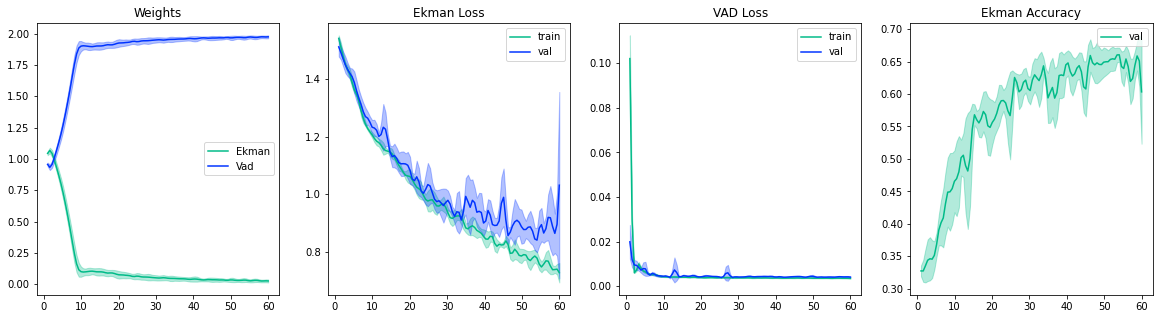

In [117]:
summary.plot_averaged_history()

In [118]:
summary.show_test_summary()

Ekman Loss: 0.942 +- 0.334
VAD Loss: 0.004 +- 0.000
Avg Loss: 0.469 +- 0.166
Avg Ekman Accuracy: 0.678 +- 0.093


## Dropout=0.5, GradNorm = 1, without L0 update

In [ ]:
summary2 = Results_Summary()
for _ in range(4):
  net = MultiheadNetwork(dropout=0.5)
  net.to(DEVICE)

  exp = TrainingManager(net, dataloader, with_gradNorm=True, alpha=1.0)
  exp.train(epochs=60, train_label='combined', val_label='combined')

  # evaluate on test set
  ekman_loss, vad_loss, loss, acc = exp._evaluate(dataloader['combined']['test'])
  # append results
  test_results = {'ekman_loss': ekman_loss.item(), 'vad_loss': vad_loss.item(), 'loss': loss.item(), 'ekman_acc': acc,}
  summary.add_history(exp.history)
  summary.add_test_results(test_results)

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.568
Epoch 1: ekman_loss = 1.556, vad_loss = 0.116
Epoch 1: val_avg_loss = 0.761
Epoch 1: ekman_loss = 1.513, vad_loss = 0.022
Epoch 1: val_ekman_accuracy = 0.331
Epoch 1: avg. loss_weights = [1.0524958372116089, 0.9475042223930359]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.9319667816162109, 0.13153982162475586]
tensor([1.6692, 0.8827], device='cuda:0')


  0%|          | 0/211 [00:00<?, ?it/s]